## Recomposição com LSTM + SVR

In [20]:
import pandas as pd
import numpy as np
import joblib
import pywt
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# === 1. Carregar e preparar a3 original ===
df = pd.read_csv("RMDM_litoral_norte_com_normalizado.csv")
serie = df["RMDM_Norm"].values

# Aplicar DWT e reconstruir a3
coeffs = pywt.wavedec(serie, 'db4', level=3)
a3 = pywt.upcoef('a', coeffs[0], 'db4', level=3)
a3 = a3[:len(serie)]

# Carregar scaler e normalizar a3
scaler_a3 = joblib.load("scaler_a3.joblib")
a3_scaled = scaler_a3.transform(a3.reshape(-1, 1)).flatten()

# Criar janelas de entrada para LSTM
look_back = 10
X_a3 = np.array([a3_scaled[i:i+look_back] for i in range(len(a3_scaled) - look_back)])
X_a3 = X_a3.reshape((X_a3.shape[0], X_a3.shape[1], 1))

# Carregar modelo LSTM e prever
lstm_model = load_model("lstm_a3_model.keras")
y_pred_a3_scaled = lstm_model.predict(X_a3)
y_pred_a3 = scaler_a3.inverse_transform(y_pred_a3_scaled).flatten()


246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [22]:
def prever_componente_svr(nome_comp, look_back=10):
    serie = pd.read_csv(f"{nome_comp}_component.csv")[nome_comp].values
    scaler = joblib.load(f"scaler_{nome_comp}.joblib")
    serie_scaled = scaler.transform(serie.reshape(-1, 1)).flatten()
    X = np.array([serie_scaled[i:i+look_back] for i in range(len(serie_scaled) - look_back)])
    modelo = joblib.load(f"svr_{nome_comp}.joblib")
    y_pred_scaled = modelo.predict(X)
    y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    return y_pred


In [23]:
y_pred_d3 = prever_componente_svr("D3")
y_pred_d2 = prever_componente_svr("D2")
y_pred_d1 = prever_componente_svr("D1")


In [24]:
# Corrigir faixa da LSTM (a3)
y_pred_a3 = scaler_a3.inverse_transform(y_pred_a3_scaled).flatten()

# Truncar todas as previsões para mesmo tamanho
min_len = min(len(y_pred_a3), len(y_pred_d3), len(y_pred_d2), len(y_pred_d1))

# Recompor previsão final
y_final = (
    y_pred_a3[:min_len] +
    y_pred_d3[:min_len] +
    y_pred_d2[:min_len] +
    y_pred_d1[:min_len]
)

# Suponha que RMDM original real esteja em:
df_real = pd.read_csv("RMDM_litoral_norte.csv")
rmdm_real = df_real["RMDM"].values[look_back:look_back + len(y_final)]

# Ajustar a soma final para casar com a escala de RMDM
final_scaler = MinMaxScaler()
final_scaler.fit(rmdm_real.reshape(-1, 1))
y_final_rescaled = final_scaler.inverse_transform(y_final.reshape(-1, 1)).flatten()


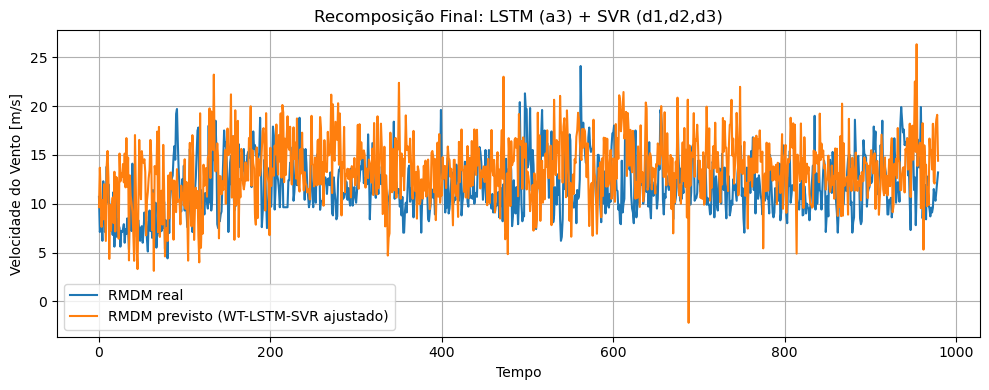

In [25]:
plt.figure(figsize=(10, 4))
plt.plot(rmdm_real, label="RMDM real")
plt.plot(y_final_rescaled, label="RMDM previsto (WT-LSTM-SVR ajustado)")


plt.title("Recomposição Final: LSTM (a3) + SVR (d1,d2,d3)")
plt.xlabel("Tempo")
plt.ylabel("Velocidade do Vento [m/s]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


🔍 Menor valor previsto em t=688: -0.33
Componentes nesse ponto:
 a3 = 0.42
 d3 = -0.07
 d2 = -0.24
 d1 = -0.44


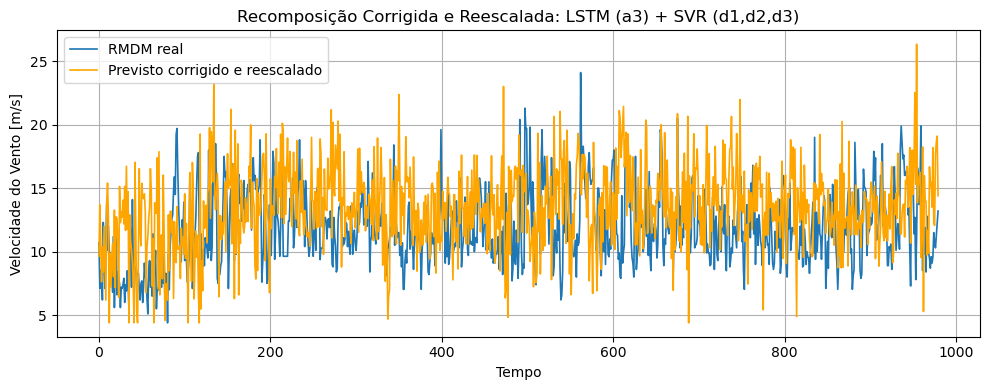

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# --- Recompor normalmente (antes da correção)
y_final = y_pred_a3[:min_len] + y_pred_d3[:min_len] + y_pred_d2[:min_len] + y_pred_d1[:min_len]

# --- Diagnóstico do valor mínimo (pico anômalo)
idx_min = np.argmin(y_final)
print(f"🔍 Menor valor previsto em t={idx_min}: {y_final[idx_min]:.2f}")
print("Componentes nesse ponto:")
print(f" a3 = {y_pred_a3[idx_min]:.2f}")
print(f" d3 = {y_pred_d3[idx_min]:.2f}")
print(f" d2 = {y_pred_d2[idx_min]:.2f}")
print(f" d1 = {y_pred_d1[idx_min]:.2f}")

# --- Correção com np.clip nos detalhes
limite = 3.0  # limitar os detalhes em ±3 m/s
y_pred_d1_corr = np.clip(y_pred_d1[:min_len], -limite, limite)
y_pred_d2_corr = np.clip(y_pred_d2[:min_len], -limite, limite)
y_pred_d3_corr = np.clip(y_pred_d3[:min_len], -limite, limite)

# --- Recomposição corrigida
y_final_corr = y_pred_a3[:min_len] + y_pred_d3_corr + y_pred_d2_corr + y_pred_d1_corr
y_final_corr = np.clip(y_final_corr, 0, None)  # velocidade mínima = 0

# === Corrigir escala com base na série RMDM real ===
df_real = pd.read_csv("RMDM_litoral_norte.csv")
rmdm_real = df_real["RMDM"].values[look_back:look_back + len(y_final_corr)]

final_scaler = MinMaxScaler()
final_scaler.fit(rmdm_real.reshape(-1, 1))
y_final_rescaled = final_scaler.inverse_transform(y_final_corr.reshape(-1, 1)).flatten()

# --- Gráfico final
plt.figure(figsize=(10, 4))
plt.plot(rmdm_real, label="RMDM real", linewidth=1.2)
plt.plot(y_final_rescaled, label="Previsto corrigido e reescalado", linewidth=1.2, color='orange')
plt.title("Recomposição Corrigida e Reescalada: LSTM (a3) + SVR (d1,d2,d3)")
plt.xlabel("Tempo")
plt.ylabel("Velocidade do Vento [m/s]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# === 1. RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(rmdm_real, y_final_rescaled))

# === 2. MAE (Mean Absolute Error)
mae = mean_absolute_error(rmdm_real, y_final_rescaled)

# === 3. C30% (Coverage dentro de ±30% do valor real)
def calcular_c30(y_real, y_pred):
    dentro = (y_pred >= 0.7 * y_real) & (y_pred <= 1.3 * y_real)
    return np.sum(dentro) / len(y_real) * 100

c30 = calcular_c30(rmdm_real, y_final_rescaled)

# === Imprimir resultados
print(f"📊 Métricas de desempenho:")
print(f"✅ RMSE: {rmse:.4f} m/s")
print(f"✅ MAE:  {mae:.4f} m/s")
print(f"✅ C30%: {c30:.2f}% das previsões dentro de ±30% do valor real")


📊 Métricas de desempenho:
✅ RMSE: 4.4705 m/s
✅ MAE:  3.5804 m/s
✅ C30%: 57.24% das previsões dentro de ±30% do valor real


## Recomposição em varios cenários - LSTM+SVR


📊 Avaliando previsão para t+1 (look_back=5)...

➡️ Usando RobustScaler para SVRs e LSTM
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
✅ RobustScaler: RMSE=9.6034 | MAE=8.7263 | MAPE=89.84% | C30=7.05%


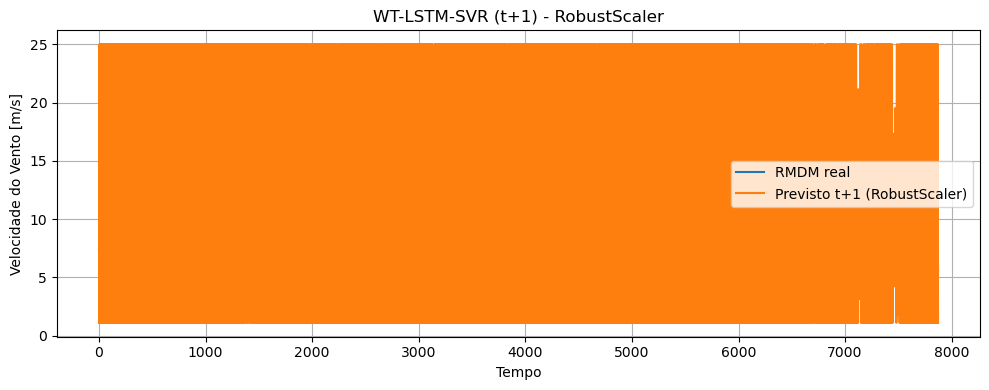


➡️ Usando StandardScaler para SVRs e LSTM
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
✅ StandardScaler: RMSE=9.6051 | MAE=8.7293 | MAPE=89.87% | C30=6.99%


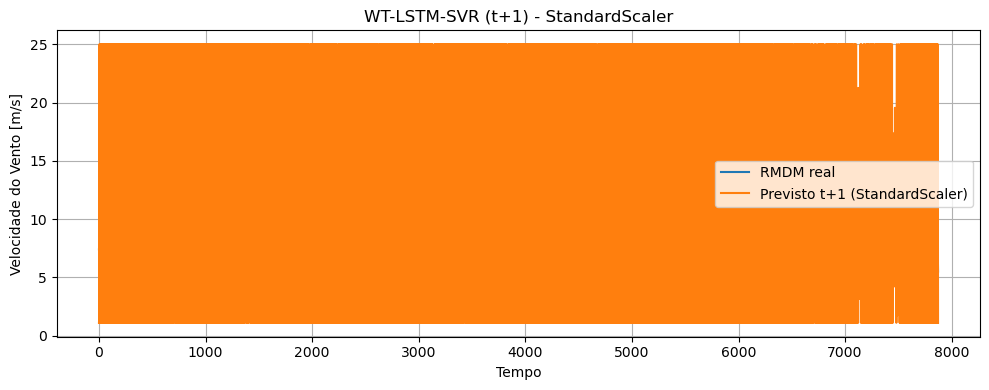


📊 Avaliando previsão para t+3 (look_back=5)...

➡️ Usando RobustScaler para SVRs e LSTM
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
✅ RobustScaler: RMSE=9.6994 | MAE=8.6714 | MAPE=90.54% | C30=9.87%


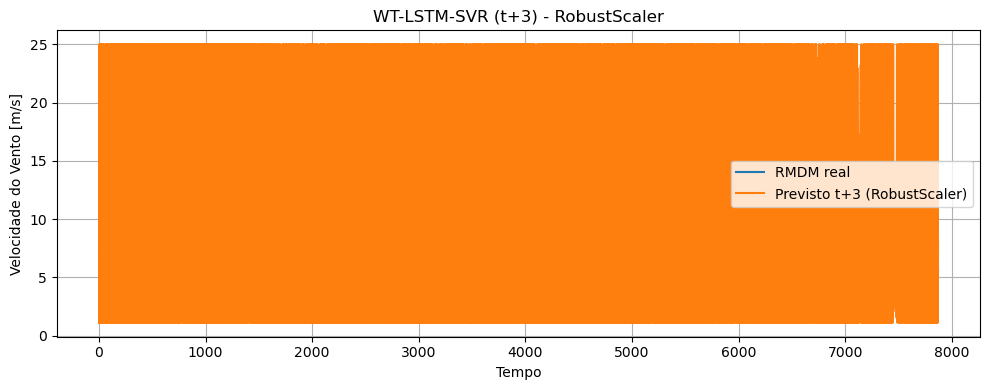


➡️ Usando StandardScaler para SVRs e LSTM
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
✅ StandardScaler: RMSE=9.7109 | MAE=8.6815 | MAPE=90.63% | C30=9.88%


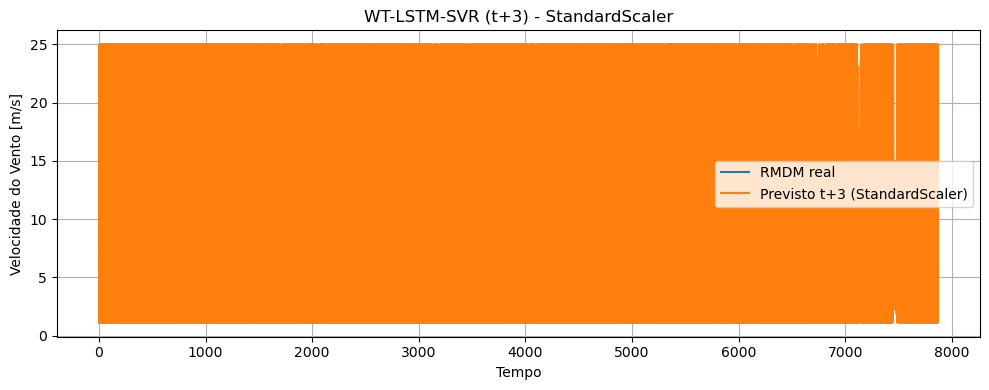


📊 Avaliando previsão para t+7 (look_back=5)...

➡️ Usando RobustScaler para SVRs e LSTM
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
✅ RobustScaler: RMSE=8.8311 | MAE=7.6143 | MAPE=80.37% | C30=17.08%


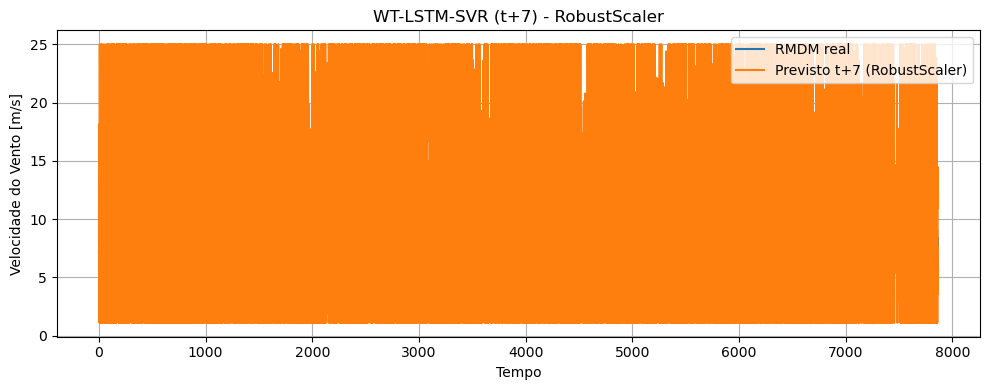


➡️ Usando StandardScaler para SVRs e LSTM
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
✅ StandardScaler: RMSE=8.8480 | MAE=7.6263 | MAPE=80.57% | C30=17.02%


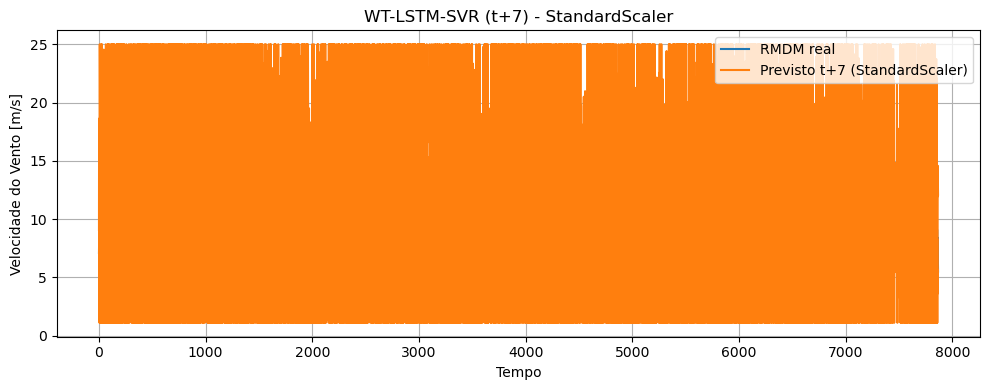


📊 Avaliando previsão para t+30 (look_back=10)...

➡️ Usando RobustScaler para SVRs e LSTM
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
✅ RobustScaler: RMSE=6.6305 | MAE=5.3473 | MAPE=56.40% | C30=32.85%


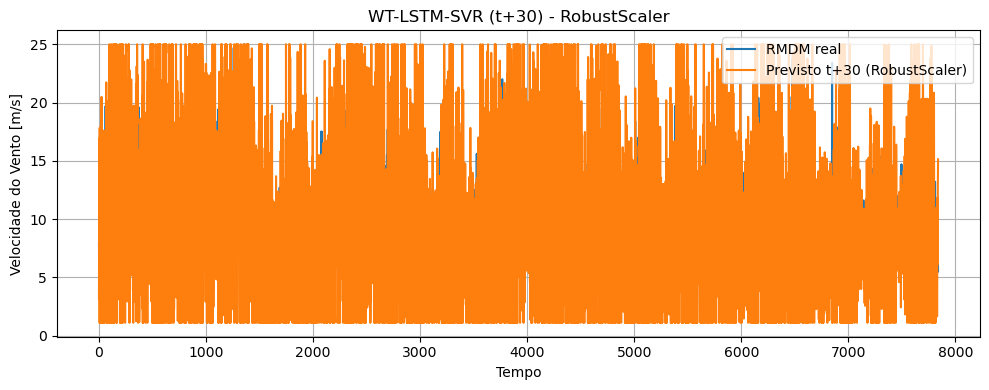


➡️ Usando StandardScaler para SVRs e LSTM
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
✅ StandardScaler: RMSE=6.6567 | MAE=5.3769 | MAPE=56.71% | C30=32.67%


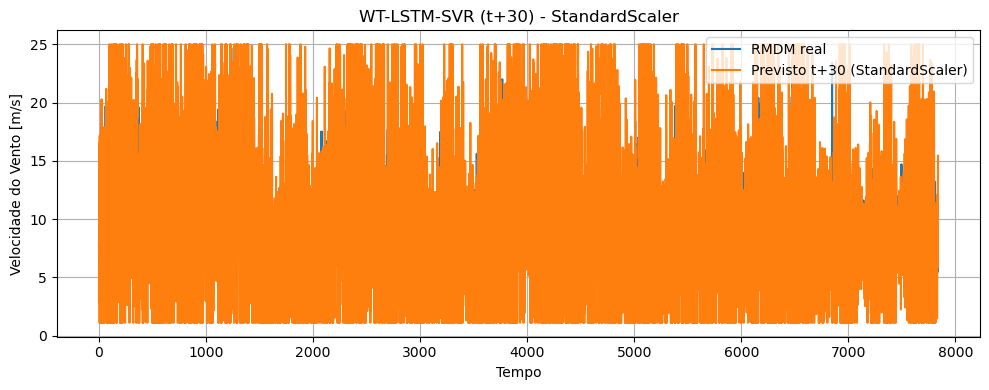


📊 Tabela final de métricas:
                                           RobustScaler  \
t+1   {'RMSE': 9.6033774544358, 'MAE': 8.72633576610...   
t+3   {'RMSE': 9.699354931760713, 'MAE': 8.671413430...   
t+7   {'RMSE': 8.831148085715016, 'MAE': 7.614290274...   
t+30  {'RMSE': 6.630469656151099, 'MAE': 5.347267688...   

                                         StandardScaler  
t+1   {'RMSE': 9.605135534340999, 'MAE': 8.729290085...  
t+3   {'RMSE': 9.71093693596407, 'MAE': 8.6814970056...  
t+7   {'RMSE': 8.847982848281031, 'MAE': 7.626324522...  
t+30  {'RMSE': 6.656729495665399, 'MAE': 5.376913290...  


In [ ]:
# Recomposição WT-LSTM-SVR com previsões armazenadas nas pastas 'lstm/' e 'modelos/'

from tensorflow.keras.models import load_model
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt
import os

# Parâmetros da normalização original
MIN_RMDM = 1.1
MAX_RMDM = 25.0

# === Função para criar dataset multi-step
def criar_dataset_multi_step(series, look_back=10, passo=1, feature_engineering=False):
    X, y = [], []
    for i in range(len(series) - look_back - passo + 1):
        features = series[i:i+look_back].copy()
        if feature_engineering:
            tendencia = features[-1] - features[0]
            media_movel = np.mean(features)
            volatilidade = np.std(features)
            features = np.append(features, [tendencia, media_movel, volatilidade])
        X.append(features)
        y.append(series[i+look_back+passo-1])
    return np.array(X), np.array(y)


# === Cálculo das métricas
def calcular_metricas(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    c30 = np.sum((y_pred >= 0.7 * y_true) & (y_pred <= 1.3 * y_true)) / len(y_true) * 100
    return rmse, mae, mape, c30

# === Previsão com SVR (Standard ou Robust)
def prever_componente_svr(nome_comp, passo, look_back, scaler_nome):
    serie = pd.read_csv(f"{nome_comp}_component.csv")[nome_comp].values
    X, _ = criar_dataset_multi_step(serie, look_back=look_back, passo=passo, feature_engineering=True)
    modelo_path = f"modelos/svr_{nome_comp}_t{passo}_{scaler_nome}_lb{look_back}.joblib"
    modelo = joblib.load(modelo_path)
    return modelo.predict(X)

# === Recomposição e avaliação final

def recompor_e_avaliar(passo):
    look_back = 5 if passo in [1, 3, 7] else 10

    print(f"\n📊 Avaliando previsão para t+{passo} (look_back={look_back})...")

    df = pd.read_csv("RMDM_corrigido.csv")
    rmdm_real = df["RMDM"].values
    df_norm = pd.read_csv("RMDM_corrigido_normalizado.csv")
    serie_norm = df_norm["RMDM_Norm"].values
    coeffs = pywt.wavedec(serie_norm, 'db4', level=3)
    a3 = pywt.upcoef('a', coeffs[0], 'db4', level=3)[:len(serie_norm)]

    X_a3, _ = criar_dataset_multi_step(a3, look_back=look_back, passo=passo)
    X_a3 = X_a3.reshape((X_a3.shape[0], X_a3.shape[1], 1))

    # Avaliação separada para cada scaler
    resultados_scalers = {}

    for scaler_nome in ["RobustScaler", "StandardScaler"]:
        print(f"\n➡️ Usando {scaler_nome} para SVRs e LSTM")

        model_a3 = load_model(f"lstm/modelo_lstm_a3_t{passo}.keras")
        y_pred_a3 = model_a3.predict(X_a3).flatten()

        y_pred_d3 = prever_componente_svr("D3", passo, look_back, scaler_nome)
        y_pred_d2 = prever_componente_svr("D2", passo, look_back, scaler_nome)
        y_pred_d1 = prever_componente_svr("D1", passo, look_back, scaler_nome)

        # Correção de picos
        limite = 3.0
        y_pred_d1 = np.clip(y_pred_d1, -limite, limite)
        y_pred_d2 = np.clip(y_pred_d2, -limite, limite)
        y_pred_d3 = np.clip(y_pred_d3, -limite, limite)

        # Recomposição
        min_len = min(len(y_pred_a3), len(y_pred_d3), len(y_pred_d2), len(y_pred_d1))
        y_final_norm = (
            y_pred_a3[:min_len] +
            y_pred_d3[:min_len] +
            y_pred_d2[:min_len] +
            y_pred_d1[:min_len]
        )

        y_final_real = y_final_norm * (MAX_RMDM - MIN_RMDM) + MIN_RMDM
        y_real = rmdm_real[look_back + passo - 1:look_back + passo - 1 + min_len]

        rmse, mae, mape, c30 = calcular_metricas(y_real, y_final_real)
        print(f"✅ {scaler_nome}: RMSE={rmse:.4f} | MAE={mae:.4f} | MAPE={mape:.2f}% | C30={c30:.2f}%")

        resultados_scalers[scaler_nome] = {
            "RMSE": rmse, "MAE": mae, "MAPE": mape, "C30": c30
        }

        # Gráfico
        plt.figure(figsize=(10, 4))
        plt.plot(y_real, label="RMDM real")
        plt.plot(y_final_real, label=f"Previsto t+{passo} ({scaler_nome})")
        plt.title(f"WT-LSTM-SVR (t+{passo}) - {scaler_nome}")
        plt.xlabel("Tempo")
        plt.ylabel("Velocidade do Vento [m/s]")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return {f"t+{passo}" : resultados_scalers }

# Avaliar para t+1, 3, 7, 30
resultados = {}
for passo in [1, 3, 7, 30]:
    res = recompor_e_avaliar(passo)
    resultados.update(res)

# Mostrar como tabela
print("\n📊 Tabela final de métricas:")
print(pd.DataFrame(resultados).T.round(3))


## Recomposição para Random Forest


📊 Avaliando RF-LSTM para t+1 (look_back=5)...
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
✅ RMSE: 4.0013 | MAE: 3.1553 | MAPE: 28.09% | C30%: 64.16%


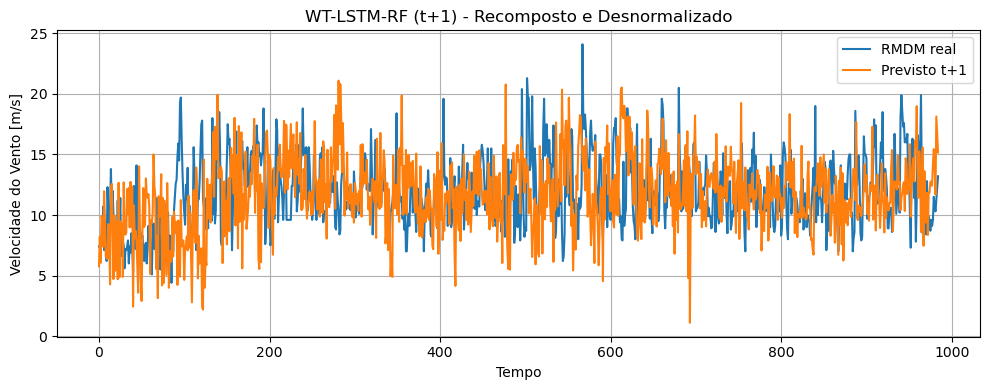


📊 Avaliando RF-LSTM para t+3 (look_back=5)...
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
✅ RMSE: 3.9931 | MAE: 3.1574 | MAPE: 27.75% | C30%: 62.77%


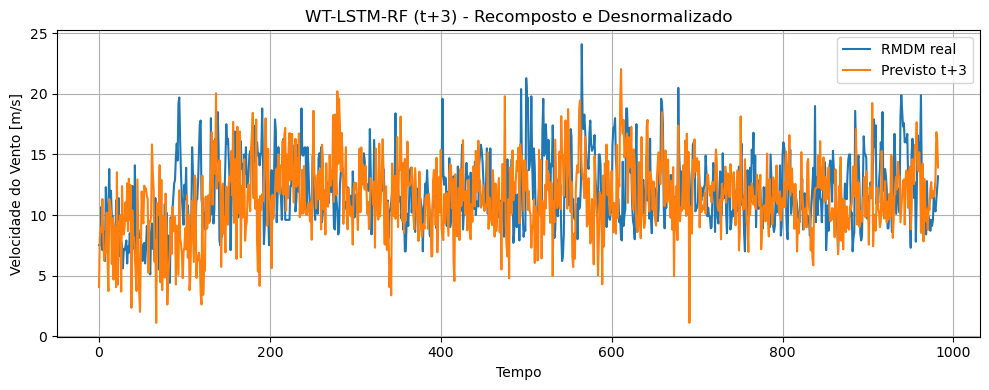


📊 Avaliando RF-LSTM para t+5 (look_back=5)...
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
✅ RMSE: 3.9352 | MAE: 3.1505 | MAPE: 28.01% | C30%: 63.71%


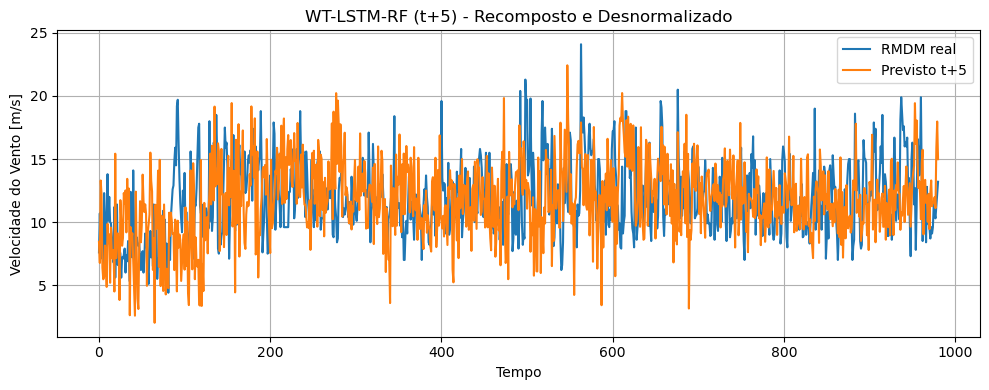


📊 Avaliando RF-LSTM para t+7 (look_back=10)...
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
✅ RMSE: 3.8133 | MAE: 3.0314 | MAPE: 26.64% | C30%: 63.35%


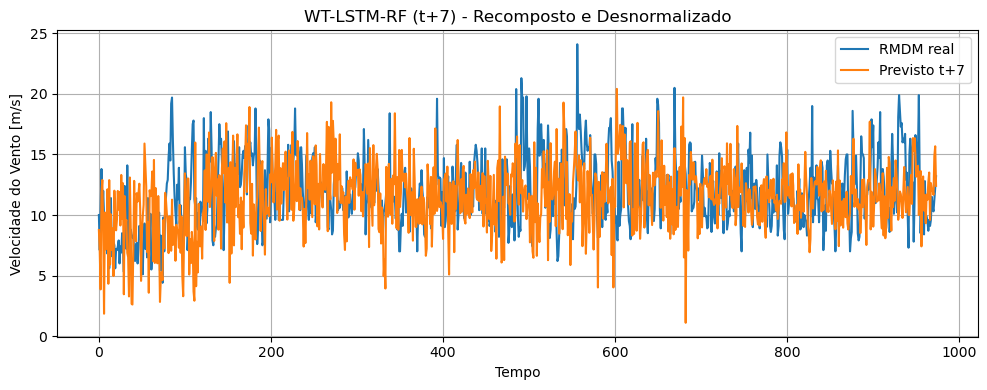


📊 Avaliando RF-LSTM para t+30 (look_back=10)...
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
✅ RMSE: 3.7769 | MAE: 2.9811 | MAPE: 25.21% | C30%: 64.56%


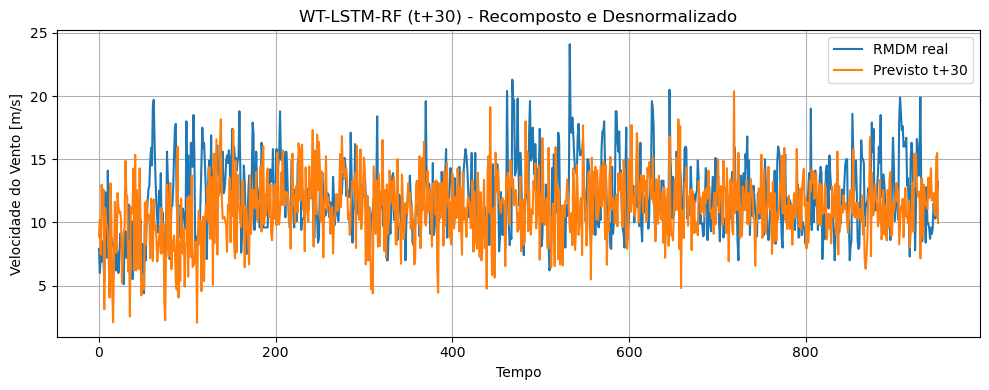


📊 Tabela final de métricas WT-LSTM-RF:
       RMSE    MAE    MAPE     C30
t+1   4.001  3.155  28.090  64.162
t+3   3.993  3.157  27.746  62.767
t+5   3.935  3.150  28.008  63.710
t+7   3.813  3.031  26.640  63.347
t+30  3.777  2.981  25.209  64.564


In [53]:
from tensorflow.keras.models import load_model
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt

# Normalização original
MIN_RMDM = 1.1
MAX_RMDM = 25.0

# Criar dataset multi-step
def criar_dataset_multi_step(series, look_back=10, passo=1):
    X, y = [], []
    for i in range(len(series) - look_back - passo + 1):
        X.append(series[i:i+look_back])
        y.append(series[i+look_back+passo-1])
    return np.array(X), np.array(y)

# Métricas
def calcular_metricas(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    c30 = np.sum((y_pred >= 0.7 * y_true) & (y_pred <= 1.3 * y_true)) / len(y_true) * 100
    return rmse, mae, mape, c30

# Prever componente com Random Forest
def prever_componente_rf(nome_comp, passo, look_back):
    serie = pd.read_csv(f"{nome_comp}_component.csv")[nome_comp].values
    X, _ = criar_dataset_multi_step(serie, look_back=look_back, passo=passo)
    modelo = joblib.load(f"rf_{nome_comp}_t{passo}.joblib")
    y_pred = modelo.predict(X)
    return y_pred

# Recomposição com RF + LSTM para A3
def recompor_e_avaliar_rf(passo):
    look_back = 5 if passo in [1, 3, 5] else 10
    print(f"\n📊 Avaliando RF-LSTM para t+{passo} (look_back={look_back})...")

    df = pd.read_csv("RMDM_corrigido.csv")
    rmdm_real = df["RMDM"].values

    df_norm = pd.read_csv("RMDM_corrigido_normalizado.csv")
    serie_norm = df_norm["RMDM_Norm"].values
    coeffs = pywt.wavedec(serie_norm, 'db4', level=3)
    a3 = pywt.upcoef('a', coeffs[0], 'db4', level=3)[:len(serie_norm)]

    X_a3, _ = criar_dataset_multi_step(a3, look_back=look_back, passo=passo)
    X_a3 = X_a3.reshape((X_a3.shape[0], X_a3.shape[1], 1))
    model_a3 = load_model(f"lstm_a3_t{passo}.keras")
    y_pred_a3 = model_a3.predict(X_a3).flatten()

    # Prever detalhes com RF
    y_pred_d3 = prever_componente_rf("D3", passo, look_back)
    y_pred_d2 = prever_componente_rf("D2", passo, look_back)
    y_pred_d1 = prever_componente_rf("D1", passo, look_back)

    # Corrigir picos
    limite = 3.0
    y_pred_d1_corr = np.clip(y_pred_d1, -limite, limite)
    y_pred_d2_corr = np.clip(y_pred_d2, -limite, limite)
    y_pred_d3_corr = np.clip(y_pred_d3, -limite, limite)

    min_len = min(len(y_pred_a3), len(y_pred_d1_corr), len(y_pred_d2_corr), len(y_pred_d3_corr))
    y_final_norm = (
        y_pred_a3[:min_len] +
        y_pred_d1_corr[:min_len] +
        y_pred_d2_corr[:min_len] +
        y_pred_d3_corr[:min_len]
    )
    y_final_norm = np.clip(y_final_norm, 0, 1)

    y_final_real = y_final_norm * (MAX_RMDM - MIN_RMDM) + MIN_RMDM
    y_real = rmdm_real[look_back + passo - 1:look_back + passo - 1 + min_len]

    rmse, mae, mape, c30 = calcular_metricas(y_real, y_final_real)
    print(f"✅ RMSE: {rmse:.4f} | MAE: {mae:.4f} | MAPE: {mape:.2f}% | C30%: {c30:.2f}%")

    plt.figure(figsize=(10, 4))
    plt.plot(y_real, label="RMDM real")
    plt.plot(y_final_real, label=f"Previsto t+{passo}")
    plt.title(f"WT-LSTM-RF (t+{passo}) - Recomposto e Desnormalizado")
    plt.xlabel("Tempo")
    plt.ylabel("Velocidade do Vento [m/s]")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {"t+{}".format(passo): {"RMSE": rmse, "MAE": mae, "MAPE": mape, "C30": c30}}

# Avaliar todos os horizontes
resultados_rf = {}
for passo in [1, 3, 5, 7, 30]:
    res = recompor_e_avaliar_rf(passo=passo)
    resultados_rf.update(res)

# Exibir tabela final
df_rf_resultados = pd.DataFrame(resultados_rf).T
print("\n📊 Tabela final de métricas WT-LSTM-RF:")
print(df_rf_resultados.round(3))


## REcomposição com XGBoost


📊 Avaliando XGB-LSTM para t+1 (look_back=5)...
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
✅ RMSE: 4.6751 | MAE: 3.7179 | MAPE: 33.34% | C30%: 54.52%


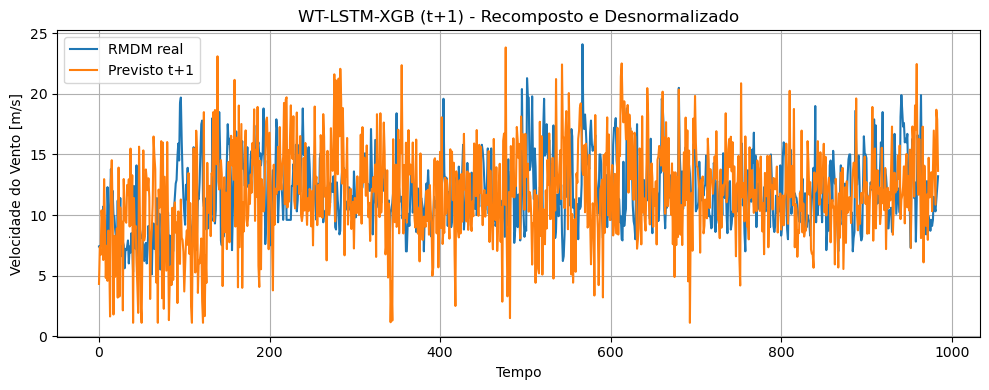


📊 Avaliando XGB-LSTM para t+3 (look_back=5)...
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
✅ RMSE: 4.6888 | MAE: 3.7321 | MAPE: 33.08% | C30%: 54.63%


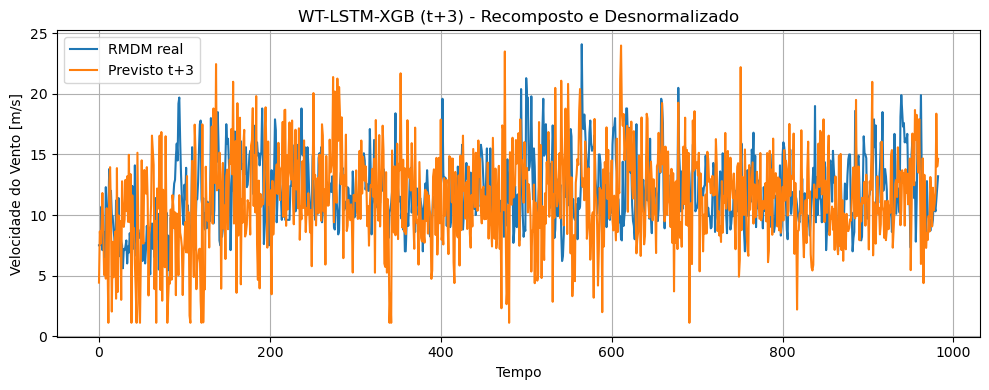


📊 Avaliando XGB-LSTM para t+5 (look_back=5)...
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
✅ RMSE: 4.6007 | MAE: 3.7184 | MAPE: 33.08% | C30%: 55.86%


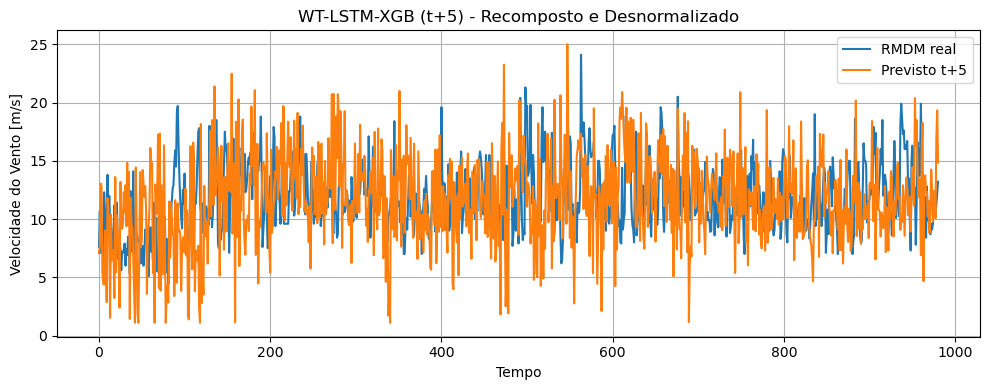


📊 Avaliando XGB-LSTM para t+7 (look_back=10)...
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
✅ RMSE: 4.6236 | MAE: 3.7138 | MAPE: 33.05% | C30%: 54.52%


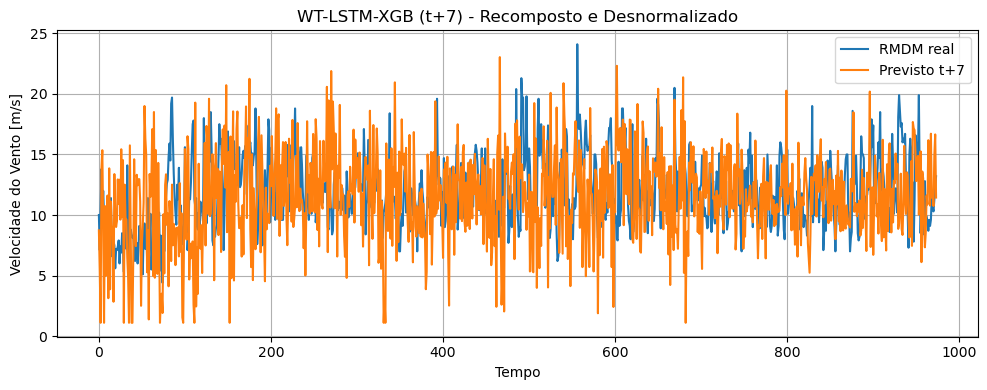


📊 Avaliando XGB-LSTM para t+30 (look_back=10)...
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
✅ RMSE: 4.6845 | MAE: 3.7267 | MAPE: 32.03% | C30%: 54.68%


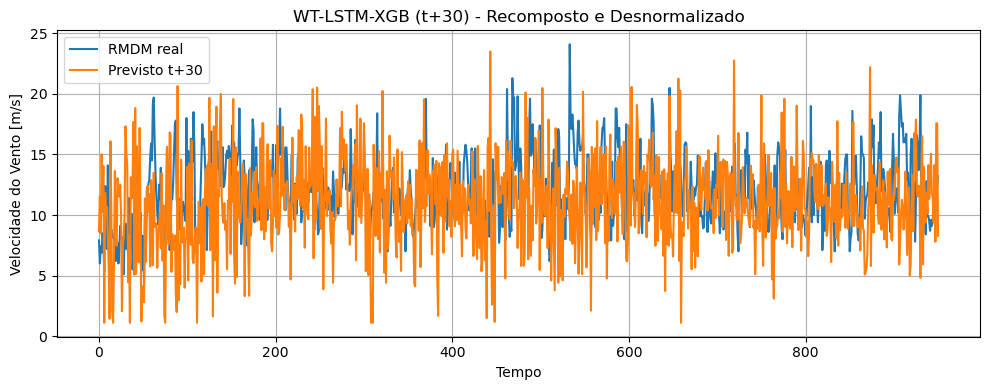


📊 Tabela final de métricas WT-LSTM-XGB:
       RMSE    MAE    MAPE     C30
t+1   4.675  3.718  33.339  54.518
t+3   4.689  3.732  33.079  54.629
t+5   4.601  3.718  33.075  55.861
t+7   4.624  3.714  33.047  54.517
t+30  4.685  3.727  32.025  54.679


In [54]:
from tensorflow.keras.models import load_model
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt

# Normalização original
MIN_RMDM = 1.1
MAX_RMDM = 25.0

# Criar dataset multi-step
def criar_dataset_multi_step(series, look_back=10, passo=1):
    X, y = [], []
    for i in range(len(series) - look_back - passo + 1):
        X.append(series[i:i+look_back])
        y.append(series[i+look_back+passo-1])
    return np.array(X), np.array(y)

# Métricas
def calcular_metricas(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    c30 = np.sum((y_pred >= 0.7 * y_true) & (y_pred <= 1.3 * y_true)) / len(y_true) * 100
    return rmse, mae, mape, c30

# Prever componente com XGBoost
def prever_componente_xgb(nome_comp, passo, look_back):
    serie = pd.read_csv(f"{nome_comp}_component.csv")[nome_comp].values
    X, _ = criar_dataset_multi_step(serie, look_back=look_back, passo=passo)
    modelo = joblib.load(f"xgb_{nome_comp}_t{passo}.joblib")
    y_pred = modelo.predict(X)
    return y_pred

# Recomposição com LSTM para A3 + XGBoost para detalhes
def recompor_e_avaliar_xgb(passo):
    look_back = 5 if passo in [1, 3, 5] else 10
    print(f"\n📊 Avaliando XGB-LSTM para t+{passo} (look_back={look_back})...")

    df = pd.read_csv("RMDM_corrigido.csv")
    rmdm_real = df["RMDM"].values

    df_norm = pd.read_csv("RMDM_corrigido_normalizado.csv")
    serie_norm = df_norm["RMDM_Norm"].values
    coeffs = pywt.wavedec(serie_norm, 'db4', level=3)
    a3 = pywt.upcoef('a', coeffs[0], 'db4', level=3)[:len(serie_norm)]

    X_a3, _ = criar_dataset_multi_step(a3, look_back=look_back, passo=passo)
    X_a3 = X_a3.reshape((X_a3.shape[0], X_a3.shape[1], 1))
    model_a3 = load_model(f"lstm_a3_t{passo}.keras")
    y_pred_a3 = model_a3.predict(X_a3).flatten()

    # Prever detalhes com XGBoost
    y_pred_d3 = prever_componente_xgb("D3", passo, look_back)
    y_pred_d2 = prever_componente_xgb("D2", passo, look_back)
    y_pred_d1 = prever_componente_xgb("D1", passo, look_back)

    # Correção de picos
    limite = 3.0
    y_pred_d1_corr = np.clip(y_pred_d1, -limite, limite)
    y_pred_d2_corr = np.clip(y_pred_d2, -limite, limite)
    y_pred_d3_corr = np.clip(y_pred_d3, -limite, limite)

    min_len = min(len(y_pred_a3), len(y_pred_d1_corr), len(y_pred_d2_corr), len(y_pred_d3_corr))
    y_final_norm = (
        y_pred_a3[:min_len] +
        y_pred_d1_corr[:min_len] +
        y_pred_d2_corr[:min_len] +
        y_pred_d3_corr[:min_len]
    )
    y_final_norm = np.clip(y_final_norm, 0, 1)

    y_final_real = y_final_norm * (MAX_RMDM - MIN_RMDM) + MIN_RMDM
    y_real = rmdm_real[look_back + passo - 1:look_back + passo - 1 + min_len]

    rmse, mae, mape, c30 = calcular_metricas(y_real, y_final_real)
    print(f"✅ RMSE: {rmse:.4f} | MAE: {mae:.4f} | MAPE: {mape:.2f}% | C30%: {c30:.2f}%")

    plt.figure(figsize=(10, 4))
    plt.plot(y_real, label="RMDM real")
    plt.plot(y_final_real, label=f"Previsto t+{passo}")
    plt.title(f"WT-LSTM-XGB (t+{passo}) - Recomposto e Desnormalizado")
    plt.xlabel("Tempo")
    plt.ylabel("Velocidade do Vento [m/s]")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {"t+{}".format(passo): {"RMSE": rmse, "MAE": mae, "MAPE": mape, "C30": c30}}

# Avaliar todos os horizontes
resultados_xgb = {}
for passo in [1, 3, 5, 7, 30]:
    res = recompor_e_avaliar_xgb(passo=passo)
    resultados_xgb.update(res)

# Exibir tabela final
df_xgb_resultados = pd.DataFrame(resultados_xgb).T
print("\n📊 Tabela final de métricas WT-LSTM-XGB:")
print(df_xgb_resultados.round(3))


## Recomposição para ExtraXGBoosting


📊 Avaliando ETR-LSTM para t+1 (look_back=5)...
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
✅ RMSE: 4.8688 | MAE: 3.8772 | MAPE: 34.76% | C30%: 53.71%


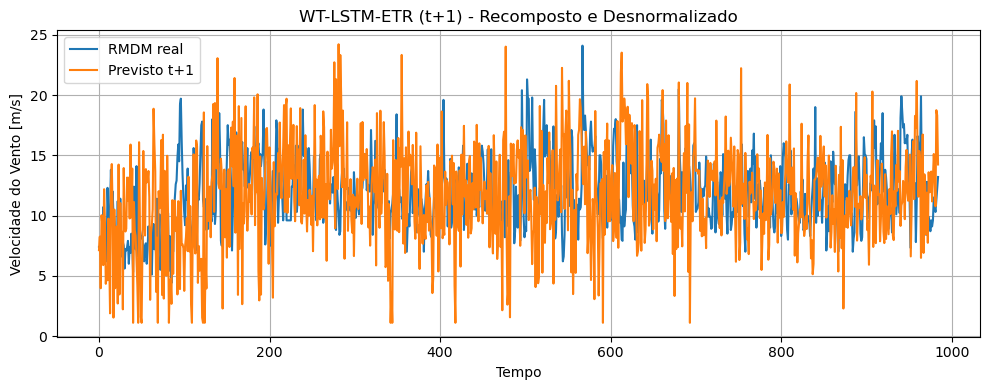


📊 Avaliando ETR-LSTM para t+3 (look_back=5)...
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
✅ RMSE: 4.8634 | MAE: 3.8706 | MAPE: 34.37% | C30%: 52.90%


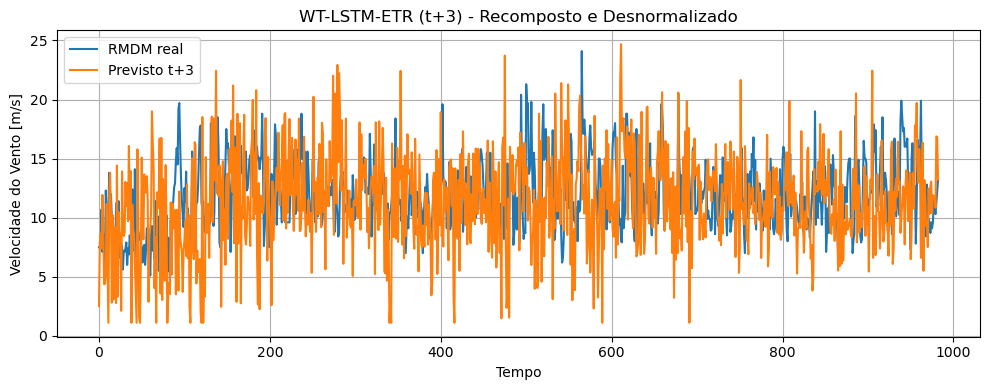


📊 Avaliando ETR-LSTM para t+5 (look_back=5)...
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
✅ RMSE: 4.7975 | MAE: 3.8528 | MAPE: 34.41% | C30%: 52.91%


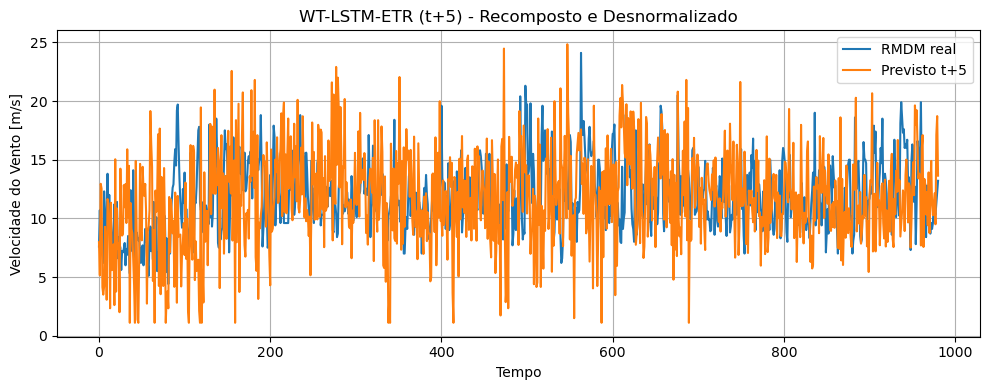


📊 Avaliando ETR-LSTM para t+7 (look_back=10)...
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
✅ RMSE: 4.7259 | MAE: 3.7858 | MAPE: 33.60% | C30%: 54.00%


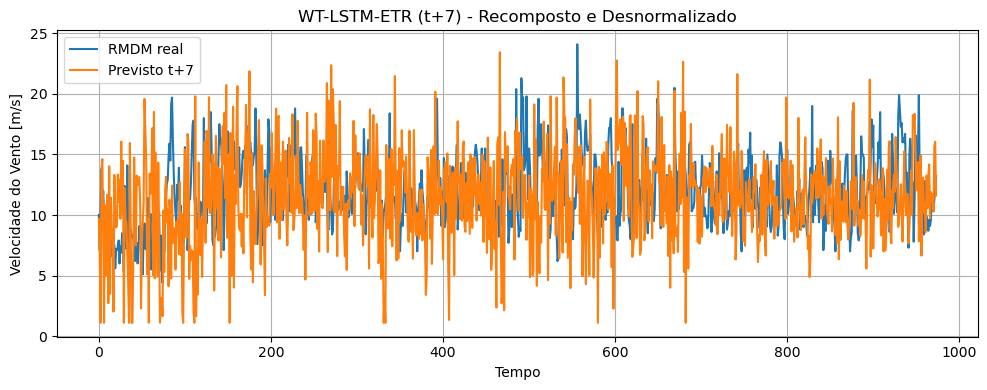


📊 Avaliando ETR-LSTM para t+30 (look_back=10)...
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
✅ RMSE: 4.7269 | MAE: 3.7505 | MAPE: 32.32% | C30%: 54.36%


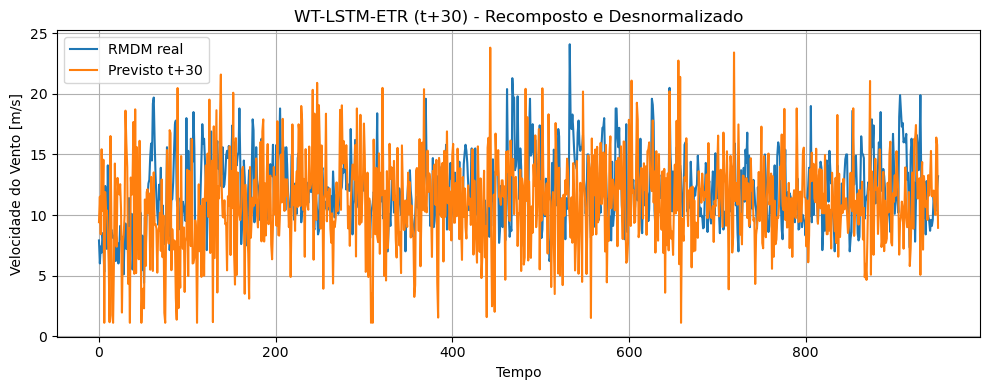


📊 Tabela final de métricas WT-LSTM-ETR:
       RMSE    MAE    MAPE     C30
t+1   4.869  3.877  34.761  53.706
t+3   4.863  3.871  34.370  52.899
t+5   4.797  3.853  34.409  52.905
t+7   4.726  3.786  33.601  54.004
t+30  4.727  3.751  32.323  54.364


In [55]:
from tensorflow.keras.models import load_model
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt

# Normalização original
MIN_RMDM = 1.1
MAX_RMDM = 25.0

# Criar dataset multi-step
def criar_dataset_multi_step(series, look_back=10, passo=1):
    X, y = [], []
    for i in range(len(series) - look_back - passo + 1):
        X.append(series[i:i+look_back])
        y.append(series[i+look_back+passo-1])
    return np.array(X), np.array(y)

# Métricas
def calcular_metricas(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    c30 = np.sum((y_pred >= 0.7 * y_true) & (y_pred <= 1.3 * y_true)) / len(y_true) * 100
    return rmse, mae, mape, c30

# Prever componente com ExtraTrees
def prever_componente_etr(nome_comp, passo, look_back):
    serie = pd.read_csv(f"{nome_comp}_component.csv")[nome_comp].values
    X, _ = criar_dataset_multi_step(serie, look_back=look_back, passo=passo)
    modelo = joblib.load(f"etr_{nome_comp}_t{passo}.joblib")
    y_pred = modelo.predict(X)
    return y_pred

# Recomposição com LSTM (A3) + ExtraTrees (D1, D2, D3)
def recompor_e_avaliar_etr(passo):
    look_back = 5 if passo in [1, 3, 5] else 10
    print(f"\n📊 Avaliando ETR-LSTM para t+{passo} (look_back={look_back})...")

    df = pd.read_csv("RMDM_corrigido.csv")
    rmdm_real = df["RMDM"].values

    df_norm = pd.read_csv("RMDM_corrigido_normalizado.csv")
    serie_norm = df_norm["RMDM_Norm"].values
    coeffs = pywt.wavedec(serie_norm, 'db4', level=3)
    a3 = pywt.upcoef('a', coeffs[0], 'db4', level=3)[:len(serie_norm)]

    X_a3, _ = criar_dataset_multi_step(a3, look_back=look_back, passo=passo)
    X_a3 = X_a3.reshape((X_a3.shape[0], X_a3.shape[1], 1))
    model_a3 = load_model(f"lstm_a3_t{passo}.keras")
    y_pred_a3 = model_a3.predict(X_a3).flatten()

    # Prever detalhes com ExtraTrees
    y_pred_d3 = prever_componente_etr("D3", passo, look_back)
    y_pred_d2 = prever_componente_etr("D2", passo, look_back)
    y_pred_d1 = prever_componente_etr("D1", passo, look_back)

    # Correção de picos
    limite = 3.0
    y_pred_d1_corr = np.clip(y_pred_d1, -limite, limite)
    y_pred_d2_corr = np.clip(y_pred_d2, -limite, limite)
    y_pred_d3_corr = np.clip(y_pred_d3, -limite, limite)

    min_len = min(len(y_pred_a3), len(y_pred_d1_corr), len(y_pred_d2_corr), len(y_pred_d3_corr))
    y_final_norm = (
        y_pred_a3[:min_len] +
        y_pred_d1_corr[:min_len] +
        y_pred_d2_corr[:min_len] +
        y_pred_d3_corr[:min_len]
    )
    y_final_norm = np.clip(y_final_norm, 0, 1)

    y_final_real = y_final_norm * (MAX_RMDM - MIN_RMDM) + MIN_RMDM
    y_real = rmdm_real[look_back + passo - 1:look_back + passo - 1 + min_len]

    rmse, mae, mape, c30 = calcular_metricas(y_real, y_final_real)
    print(f"✅ RMSE: {rmse:.4f} | MAE: {mae:.4f} | MAPE: {mape:.2f}% | C30%: {c30:.2f}%")

    plt.figure(figsize=(10, 4))
    plt.plot(y_real, label="RMDM real")
    plt.plot(y_final_real, label=f"Previsto t+{passo}")
    plt.title(f"WT-LSTM-ETR (t+{passo}) - Recomposto e Desnormalizado")
    plt.xlabel("Tempo")
    plt.ylabel("Velocidade do Vento [m/s]")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {"t+{}".format(passo): {"RMSE": rmse, "MAE": mae, "MAPE": mape, "C30": c30}}

# Avaliar todos os horizontes
resultados_etr = {}
for passo in [1, 3, 5, 7, 30]:
    res = recompor_e_avaliar_etr(passo=passo)
    resultados_etr.update(res)

# Exibir tabela final
df_etr_resultados = pd.DataFrame(resultados_etr).T
print("\n📊 Tabela final de métricas WT-LSTM-ETR:")
print(df_etr_resultados.round(3))


## Recompor para LightXGBM


📊 Avaliando LGBM-LSTM para t+1 (look_back=5)...
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


C:\Users\marco\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\marco\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


✅ RMSE: 4.1190 | MAE: 3.2322 | MAPE: 28.85% | C30%: 62.34%


C:\Users\marco\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


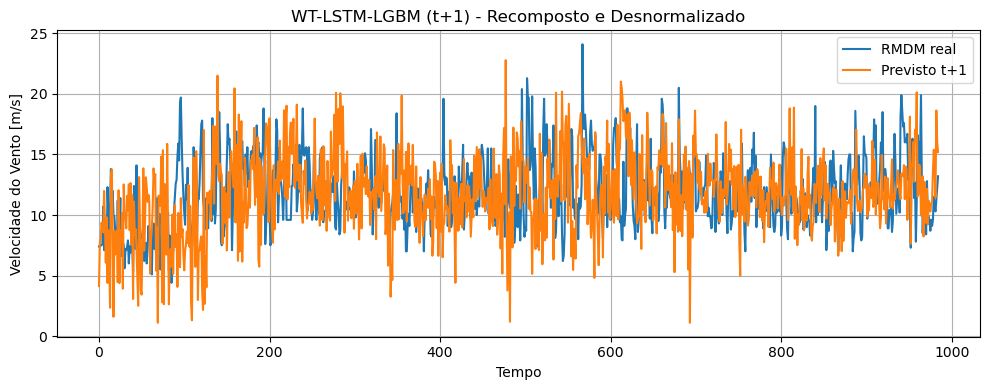


📊 Avaliando LGBM-LSTM para t+3 (look_back=5)...
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
✅ RMSE: 4.1244 | MAE: 3.2534 | MAPE: 28.69% | C30%: 61.14%


C:\Users\marco\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\marco\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\marco\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


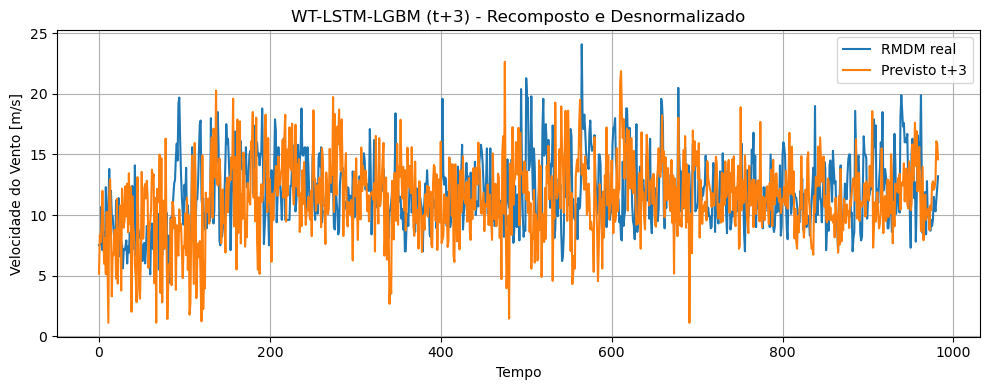


📊 Avaliando LGBM-LSTM para t+5 (look_back=5)...
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
✅ RMSE: 4.0704 | MAE: 3.2417 | MAPE: 28.81% | C30%: 62.28%


C:\Users\marco\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\marco\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\marco\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


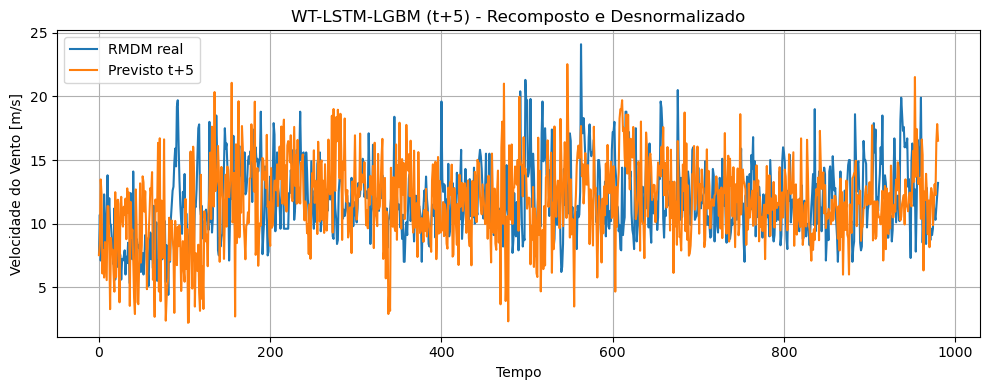


📊 Avaliando LGBM-LSTM para t+7 (look_back=10)...
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
✅ RMSE: 4.1195 | MAE: 3.2838 | MAPE: 29.12% | C30%: 61.81%


C:\Users\marco\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\marco\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\marco\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


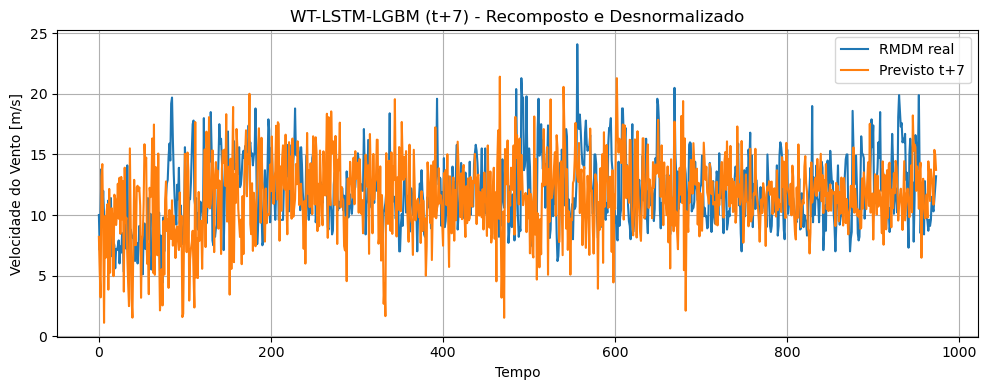


📊 Avaliando LGBM-LSTM para t+30 (look_back=10)...
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
✅ RMSE: 4.1401 | MAE: 3.2757 | MAPE: 27.91% | C30%: 61.20%


C:\Users\marco\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\marco\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\marco\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


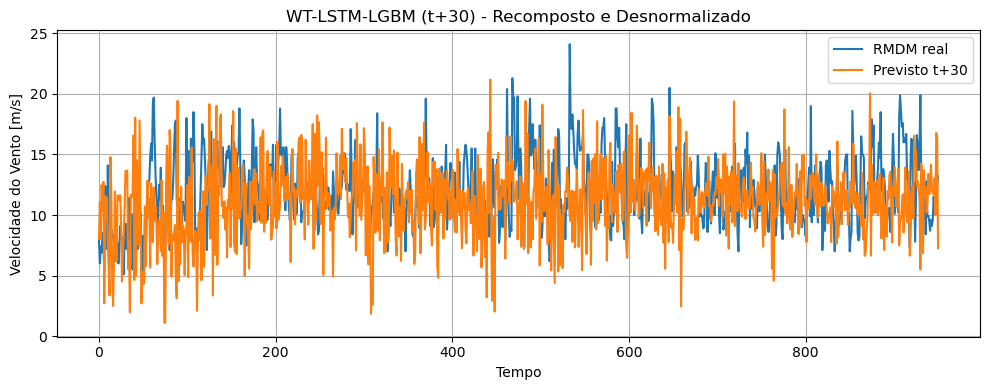


📊 Tabela final de métricas WT-LSTM-LGBM:
       RMSE    MAE    MAPE     C30
t+1   4.119  3.232  28.853  62.335
t+3   4.124  3.253  28.690  61.139
t+5   4.070  3.242  28.810  62.283
t+7   4.119  3.284  29.119  61.807
t+30  4.140  3.276  27.914  61.199


In [56]:
from tensorflow.keras.models import load_model
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt

# Normalização original
MIN_RMDM = 1.1
MAX_RMDM = 25.0

# Criar dataset multi-step
def criar_dataset_multi_step(series, look_back=10, passo=1):
    X, y = [], []
    for i in range(len(series) - look_back - passo + 1):
        X.append(series[i:i+look_back])
        y.append(series[i+look_back+passo-1])
    return np.array(X), np.array(y)

# Métricas
def calcular_metricas(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    c30 = np.sum((y_pred >= 0.7 * y_true) & (y_pred <= 1.3 * y_true)) / len(y_true) * 100
    return rmse, mae, mape, c30

# Prever componente com LightGBM
def prever_componente_lgbm(nome_comp, passo, look_back):
    serie = pd.read_csv(f"{nome_comp}_component.csv")[nome_comp].values
    X, _ = criar_dataset_multi_step(serie, look_back=look_back, passo=passo)
    modelo = joblib.load(f"lgbm_{nome_comp}_t{passo}.joblib")
    y_pred = modelo.predict(X)
    return y_pred

# Recomposição com LSTM (A3) + LightGBM (D1, D2, D3)
def recompor_e_avaliar_lgbm(passo):
    look_back = 5 if passo in [1, 3, 5] else 10
    print(f"\n📊 Avaliando LGBM-LSTM para t+{passo} (look_back={look_back})...")

    df = pd.read_csv("RMDM_corrigido.csv")
    rmdm_real = df["RMDM"].values

    df_norm = pd.read_csv("RMDM_corrigido_normalizado.csv")
    serie_norm = df_norm["RMDM_Norm"].values
    coeffs = pywt.wavedec(serie_norm, 'db4', level=3)
    a3 = pywt.upcoef('a', coeffs[0], 'db4', level=3)[:len(serie_norm)]

    X_a3, _ = criar_dataset_multi_step(a3, look_back=look_back, passo=passo)
    X_a3 = X_a3.reshape((X_a3.shape[0], X_a3.shape[1], 1))
    model_a3 = load_model(f"lstm_a3_t{passo}.keras")
    y_pred_a3 = model_a3.predict(X_a3).flatten()

    # Prever detalhes com LightGBM
    y_pred_d3 = prever_componente_lgbm("D3", passo, look_back)
    y_pred_d2 = prever_componente_lgbm("D2", passo, look_back)
    y_pred_d1 = prever_componente_lgbm("D1", passo, look_back)

    # Correção de picos
    limite = 3.0
    y_pred_d1_corr = np.clip(y_pred_d1, -limite, limite)
    y_pred_d2_corr = np.clip(y_pred_d2, -limite, limite)
    y_pred_d3_corr = np.clip(y_pred_d3, -limite, limite)

    min_len = min(len(y_pred_a3), len(y_pred_d1_corr), len(y_pred_d2_corr), len(y_pred_d3_corr))
    y_final_norm = (
        y_pred_a3[:min_len] +
        y_pred_d1_corr[:min_len] +
        y_pred_d2_corr[:min_len] +
        y_pred_d3_corr[:min_len]
    )
    y_final_norm = np.clip(y_final_norm, 0, 1)

    y_final_real = y_final_norm * (MAX_RMDM - MIN_RMDM) + MIN_RMDM
    y_real = rmdm_real[look_back + passo - 1:look_back + passo - 1 + min_len]

    rmse, mae, mape, c30 = calcular_metricas(y_real, y_final_real)
    print(f"✅ RMSE: {rmse:.4f} | MAE: {mae:.4f} | MAPE: {mape:.2f}% | C30%: {c30:.2f}%")

    plt.figure(figsize=(10, 4))
    plt.plot(y_real, label="RMDM real")
    plt.plot(y_final_real, label=f"Previsto t+{passo}")
    plt.title(f"WT-LSTM-LGBM (t+{passo}) - Recomposto e Desnormalizado")
    plt.xlabel("Tempo")
    plt.ylabel("Velocidade do Vento [m/s]")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {"t+{}".format(passo): {"RMSE": rmse, "MAE": mae, "MAPE": mape, "C30": c30}}

# Avaliar todos os horizontes
resultados_lgbm = {}
for passo in [1, 3, 5, 7, 30]:
    res = recompor_e_avaliar_lgbm(passo=passo)
    resultados_lgbm.update(res)

# Exibir tabela final
df_lgbm_resultados = pd.DataFrame(resultados_lgbm).T
print("\n📊 Tabela final de métricas WT-LSTM-LGBM:")
print(df_lgbm_resultados.round(3))


## Usando o CatBoosting


📊 Avaliando CatBoost-LSTM para t+1 (look_back=5)...
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
✅ RMSE: 3.9679 | MAE: 3.1062 | MAPE: 27.79% | C30%: 63.45%


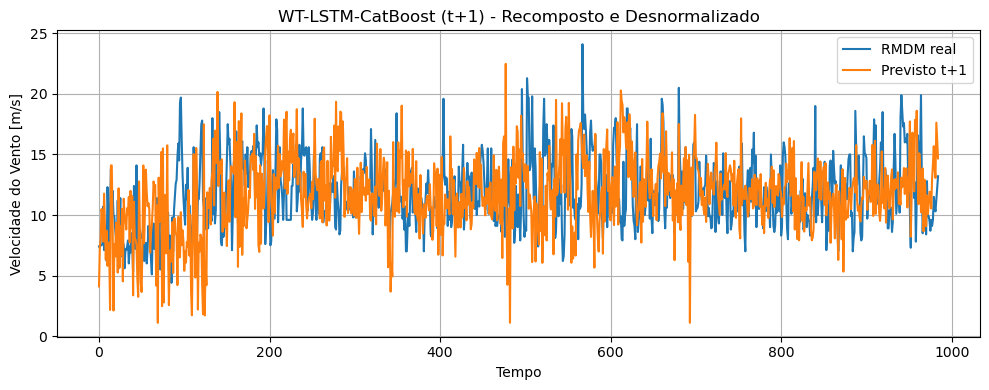


📊 Avaliando CatBoost-LSTM para t+3 (look_back=5)...
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
✅ RMSE: 3.9320 | MAE: 3.0979 | MAPE: 27.28% | C30%: 64.90%


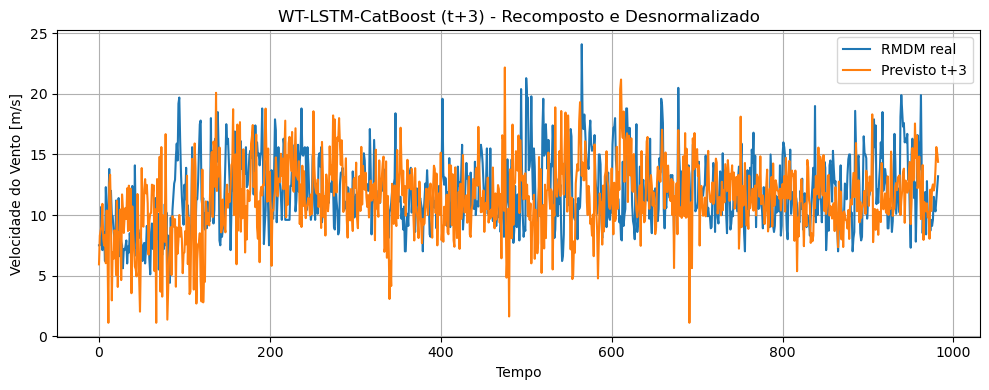


📊 Avaliando CatBoost-LSTM para t+5 (look_back=5)...
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
✅ RMSE: 3.9062 | MAE: 3.1181 | MAPE: 27.68% | C30%: 65.14%


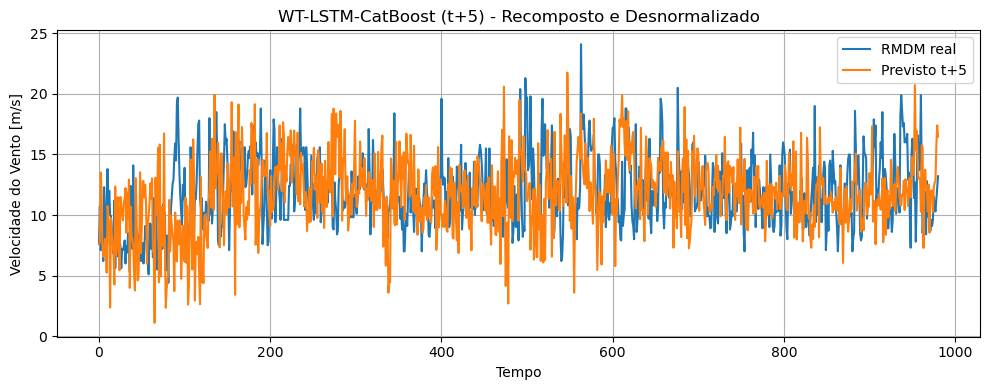


📊 Avaliando CatBoost-LSTM para t+7 (look_back=10)...
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
✅ RMSE: 4.0520 | MAE: 3.2226 | MAPE: 28.44% | C30%: 60.78%


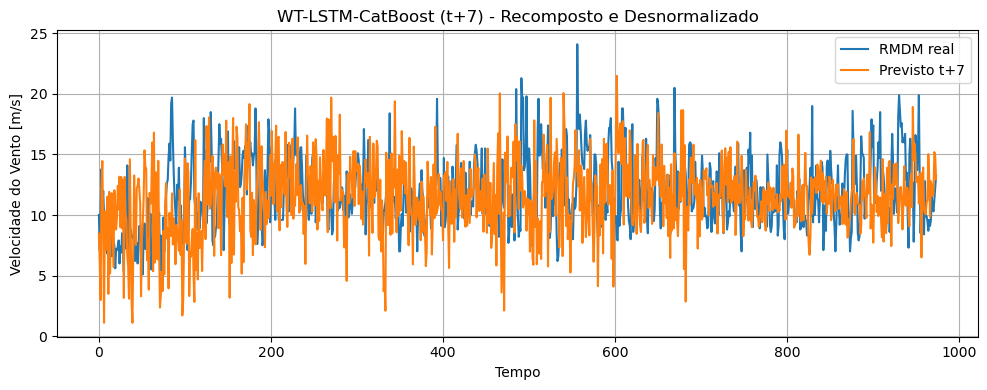


📊 Avaliando CatBoost-LSTM para t+30 (look_back=10)...
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
✅ RMSE: 4.0560 | MAE: 3.1939 | MAPE: 27.13% | C30%: 62.99%


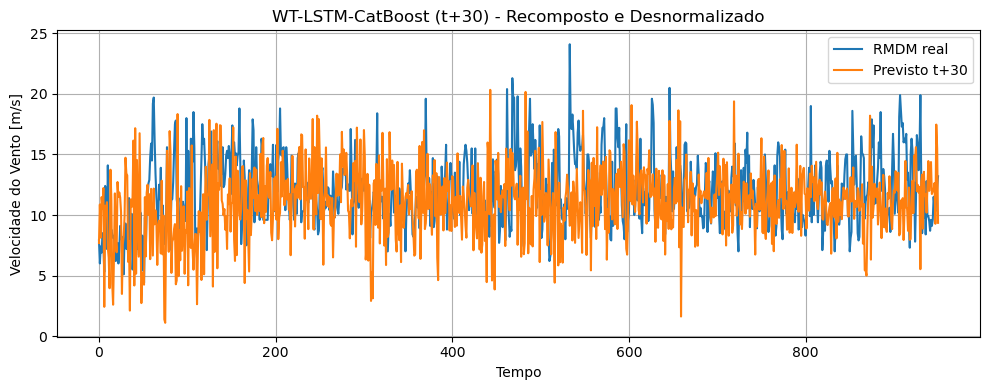


📊 Tabela final de métricas WT-LSTM-CatBoost:
       RMSE    MAE    MAPE     C30
t+1   3.968  3.106  27.791  63.452
t+3   3.932  3.098  27.278  64.903
t+5   3.906  3.118  27.679  65.138
t+7   4.052  3.223  28.440  60.780
t+30  4.056  3.194  27.127  62.986


In [57]:
from tensorflow.keras.models import load_model
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt

# Normalização original
MIN_RMDM = 1.1
MAX_RMDM = 25.0

# Criar dataset multi-step
def criar_dataset_multi_step(series, look_back=10, passo=1):
    X, y = [], []
    for i in range(len(series) - look_back - passo + 1):
        X.append(series[i:i+look_back])
        y.append(series[i+look_back+passo-1])
    return np.array(X), np.array(y)

# Métricas
def calcular_metricas(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    c30 = np.sum((y_pred >= 0.7 * y_true) & (y_pred <= 1.3 * y_true)) / len(y_true) * 100
    return rmse, mae, mape, c30

# Prever componente com CatBoost
def prever_componente_catboost(nome_comp, passo, look_back):
    serie = pd.read_csv(f"{nome_comp}_component.csv")[nome_comp].values
    X, _ = criar_dataset_multi_step(serie, look_back=look_back, passo=passo)
    modelo = joblib.load(f"catboost_{nome_comp}_t{passo}.joblib")
    y_pred = modelo.predict(X)
    return y_pred

# Recomposição com LSTM + CatBoost
def recompor_e_avaliar_catboost(passo):
    look_back = 5 if passo in [1, 3, 5] else 10
    print(f"\n📊 Avaliando CatBoost-LSTM para t+{passo} (look_back={look_back})...")

    df = pd.read_csv("RMDM_corrigido.csv")
    rmdm_real = df["RMDM"].values

    df_norm = pd.read_csv("RMDM_corrigido_normalizado.csv")
    serie_norm = df_norm["RMDM_Norm"].values
    coeffs = pywt.wavedec(serie_norm, 'db4', level=3)
    a3 = pywt.upcoef('a', coeffs[0], 'db4', level=3)[:len(serie_norm)]

    X_a3, _ = criar_dataset_multi_step(a3, look_back=look_back, passo=passo)
    X_a3 = X_a3.reshape((X_a3.shape[0], X_a3.shape[1], 1))
    model_a3 = load_model(f"lstm_a3_t{passo}.keras")
    y_pred_a3 = model_a3.predict(X_a3).flatten()

    # Prever detalhes com CatBoost
    y_pred_d3 = prever_componente_catboost("D3", passo, look_back)
    y_pred_d2 = prever_componente_catboost("D2", passo, look_back)
    y_pred_d1 = prever_componente_catboost("D1", passo, look_back)

    # Correção de picos
    limite = 3.0
    y_pred_d1_corr = np.clip(y_pred_d1, -limite, limite)
    y_pred_d2_corr = np.clip(y_pred_d2, -limite, limite)
    y_pred_d3_corr = np.clip(y_pred_d3, -limite, limite)

    min_len = min(len(y_pred_a3), len(y_pred_d1_corr), len(y_pred_d2_corr), len(y_pred_d3_corr))
    y_final_norm = (
        y_pred_a3[:min_len] +
        y_pred_d1_corr[:min_len] +
        y_pred_d2_corr[:min_len] +
        y_pred_d3_corr[:min_len]
    )
    y_final_norm = np.clip(y_final_norm, 0, 1)

    y_final_real = y_final_norm * (MAX_RMDM - MIN_RMDM) + MIN_RMDM
    y_real = rmdm_real[look_back + passo - 1:look_back + passo - 1 + min_len]

    rmse, mae, mape, c30 = calcular_metricas(y_real, y_final_real)
    print(f"✅ RMSE: {rmse:.4f} | MAE: {mae:.4f} | MAPE: {mape:.2f}% | C30%: {c30:.2f}%")

    plt.figure(figsize=(10, 4))
    plt.plot(y_real, label="RMDM real")
    plt.plot(y_final_real, label=f"Previsto t+{passo}")
    plt.title(f"WT-LSTM-CatBoost (t+{passo}) - Recomposto e Desnormalizado")
    plt.xlabel("Tempo")
    plt.ylabel("Velocidade do Vento [m/s]")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {"t+{}".format(passo): {"RMSE": rmse, "MAE": mae, "MAPE": mape, "C30": c30}}

# Avaliar todos os horizontes
resultados_catboost = {}
for passo in [1, 3, 5, 7, 30]:
    res = recompor_e_avaliar_catboost(passo=passo)
    resultados_catboost.update(res)

# Exibir tabela final
df_catboost_resultados = pd.DataFrame(resultados_catboost).T
print("\n📊 Tabela final de métricas WT-LSTM-CatBoost:")
print(df_catboost_resultados.round(3))


## Recomposição para MLPRegressor


📊 Avaliando LSTM + MLP Média para t+1 (look_back=5)...
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
✅ RMSE: 3.2135 | MAE: 2.5263 | MAPE: 22.30% | C30%: 72.49%


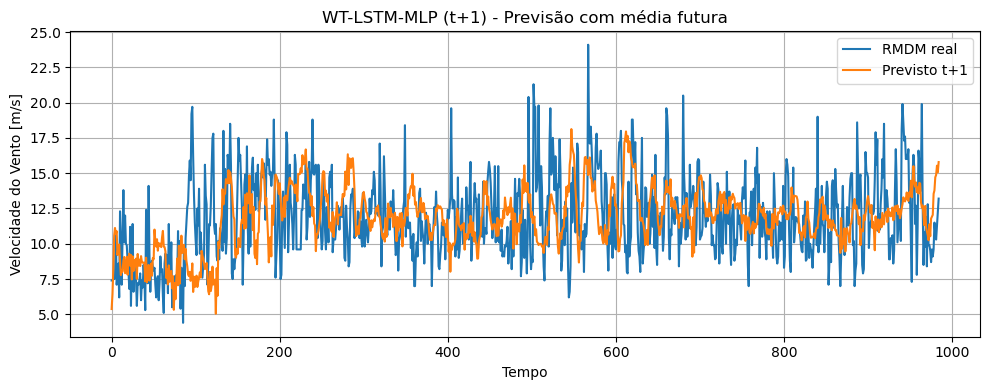


📊 Avaliando LSTM + MLP Média para t+3 (look_back=5)...
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
✅ RMSE: 3.1562 | MAE: 2.4725 | MAPE: 21.50% | C30%: 75.58%


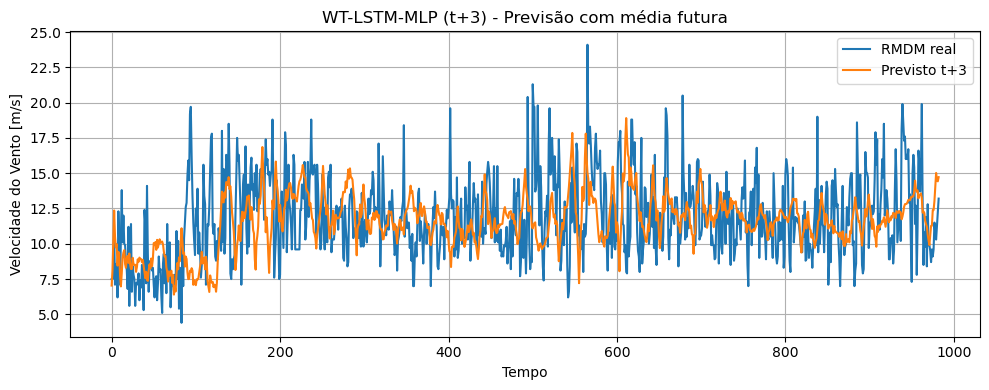


📊 Avaliando LSTM + MLP Média para t+5 (look_back=5)...
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
✅ RMSE: 3.1328 | MAE: 2.4789 | MAPE: 22.09% | C30%: 74.92%


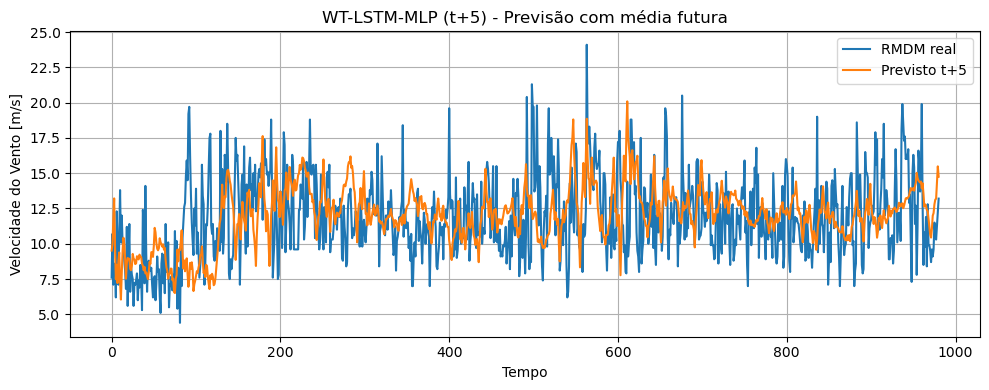


📊 Avaliando LSTM + MLP Média para t+7 (look_back=10)...
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
✅ RMSE: 2.9835 | MAE: 2.3349 | MAPE: 20.21% | C30%: 77.41%


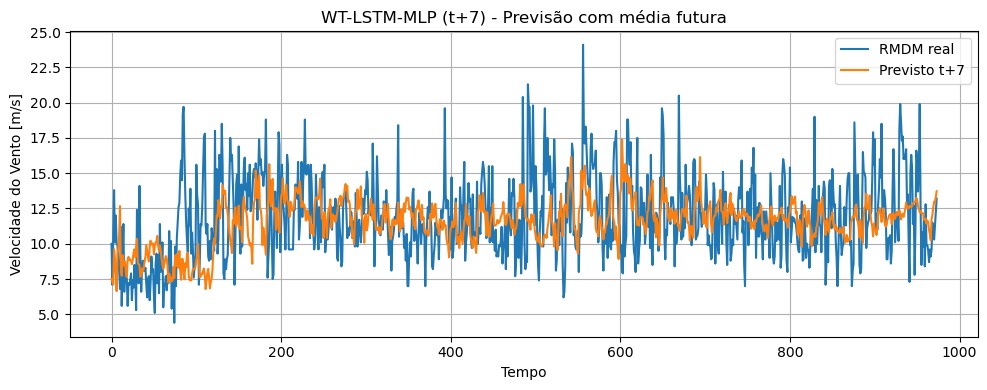


📊 Avaliando LSTM + MLP Média para t+30 (look_back=10)...
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
✅ RMSE: 2.9852 | MAE: 2.2467 | MAPE: 18.32% | C30%: 82.65%


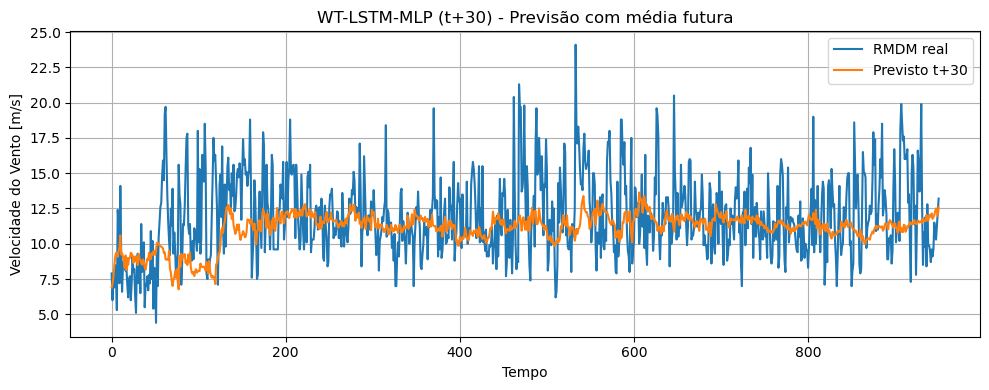


📊 Tabela final de métricas WT-LSTM-MLP Média:
       RMSE    MAE    MAPE     C30
t+1   3.213  2.526  22.299  72.487
t+3   3.156  2.473  21.504  75.585
t+5   3.133  2.479  22.091  74.924
t+7   2.983  2.335  20.205  77.413
t+30  2.985  2.247  18.317  82.650


In [58]:
from tensorflow.keras.models import load_model
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt

# Normalização original
MIN_RMDM = 1.1
MAX_RMDM = 25.0

# Criar dataset multi-step
def criar_dataset_com_media_futura(series, look_back=10, passo=1):
    X, y = [], []
    for i in range(len(series) - look_back - passo + 1):
        entrada = series[i:i+look_back]
        janela_futura = series[i+look_back:i+look_back+passo]
        media_futura = np.mean(janela_futura)
        X.append(entrada)
        y.append(media_futura)
    return np.array(X), np.array(y)

# Métricas
def calcular_metricas(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    c30 = np.sum((y_pred >= 0.7 * y_true) & (y_pred <= 1.3 * y_true)) / len(y_true) * 100
    return rmse, mae, mape, c30

# Previsão com MLP média
def prever_componente_mlp_media(nome_comp, passo, look_back):
    serie = pd.read_csv(f"{nome_comp}_component.csv")[nome_comp].values
    X, _ = criar_dataset_com_media_futura(serie, look_back=look_back, passo=passo)
    modelo = joblib.load(f"mlpavg_{nome_comp}_t{passo}.joblib")
    y_pred = modelo.predict(X)
    return y_pred

# Recomposição e avaliação
def recompor_e_avaliar_mlpavg(passo):
    look_back = 5 if passo in [1, 3, 5] else 10
    print(f"\n📊 Avaliando LSTM + MLP Média para t+{passo} (look_back={look_back})...")

    df = pd.read_csv("RMDM_corrigido.csv")
    rmdm_real = df["RMDM"].values

    df_norm = pd.read_csv("RMDM_corrigido_normalizado.csv")
    serie_norm = df_norm["RMDM_Norm"].values
    coeffs = pywt.wavedec(serie_norm, 'db4', level=3)
    a3 = pywt.upcoef('a', coeffs[0], 'db4', level=3)[:len(serie_norm)]

    X_a3, _ = criar_dataset_com_media_futura(a3, look_back=look_back, passo=passo)
    X_a3 = X_a3.reshape((X_a3.shape[0], X_a3.shape[1], 1))
    model_a3 = load_model(f"lstm_a3_t{passo}.keras")
    y_pred_a3 = model_a3.predict(X_a3).flatten()

    # Previsão dos detalhes
    y_pred_d3 = prever_componente_mlp_media("D3", passo, look_back)
    y_pred_d2 = prever_componente_mlp_media("D2", passo, look_back)
    y_pred_d1 = prever_componente_mlp_media("D1", passo, look_back)

    # Correção de picos
    limite = 3.0
    y_pred_d1_corr = np.clip(y_pred_d1, -limite, limite)
    y_pred_d2_corr = np.clip(y_pred_d2, -limite, limite)
    y_pred_d3_corr = np.clip(y_pred_d3, -limite, limite)

    min_len = min(len(y_pred_a3), len(y_pred_d1_corr), len(y_pred_d2_corr), len(y_pred_d3_corr))
    y_final_norm = (
        y_pred_a3[:min_len] +
        y_pred_d1_corr[:min_len] +
        y_pred_d2_corr[:min_len] +
        y_pred_d3_corr[:min_len]
    )
    y_final_norm = np.clip(y_final_norm, 0, 1)

    y_final_real = y_final_norm * (MAX_RMDM - MIN_RMDM) + MIN_RMDM
    y_real = rmdm_real[look_back + passo - 1:look_back + passo - 1 + min_len]

    rmse, mae, mape, c30 = calcular_metricas(y_real, y_final_real)
    print(f"✅ RMSE: {rmse:.4f} | MAE: {mae:.4f} | MAPE: {mape:.2f}% | C30%: {c30:.2f}%")

    plt.figure(figsize=(10, 4))
    plt.plot(y_real, label="RMDM real")
    plt.plot(y_final_real, label=f"Previsto t+{passo}")
    plt.title(f"WT-LSTM-MLP (t+{passo}) - Previsão com média futura")
    plt.xlabel("Tempo")
    plt.ylabel("Velocidade do Vento [m/s]")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {"t+{}".format(passo): {"RMSE": rmse, "MAE": mae, "MAPE": mape, "C30": c30}}

# Avaliar todos os horizontes
resultados_mlpavg = {}
for passo in [1, 3, 5, 7, 30]:
    res = recompor_e_avaliar_mlpavg(passo=passo)
    resultados_mlpavg.update(res)

# Tabela final
df_mlpavg_resultados = pd.DataFrame(resultados_mlpavg).T
print("\n📊 Tabela final de métricas WT-LSTM-MLP Média:")
print(df_mlpavg_resultados.round(3))



📊 Avaliando LSTM + MLP Média para t+1 (look_back=5)...
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
✅ RMSE: 0.1345 | MAE: 0.1057 | MAPE: 24.99% | C30%: 67.31%


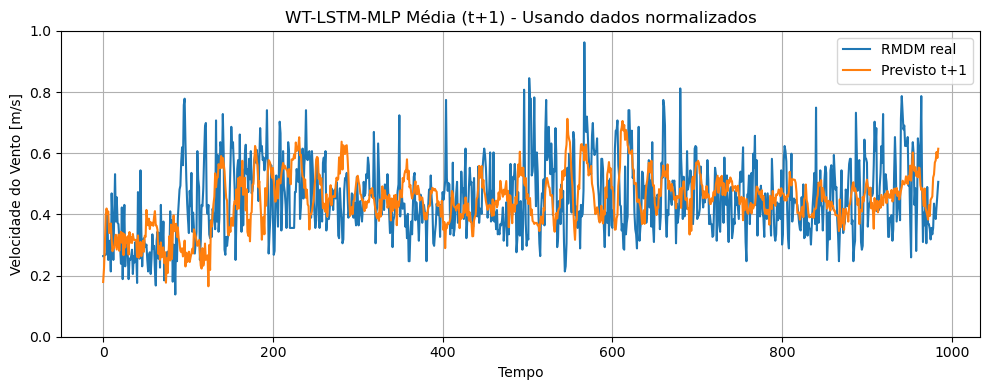


📊 Avaliando LSTM + MLP Média para t+3 (look_back=5)...
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
✅ RMSE: 0.1121 | MAE: 0.0865 | MAPE: 19.45% | C30%: 79.35%


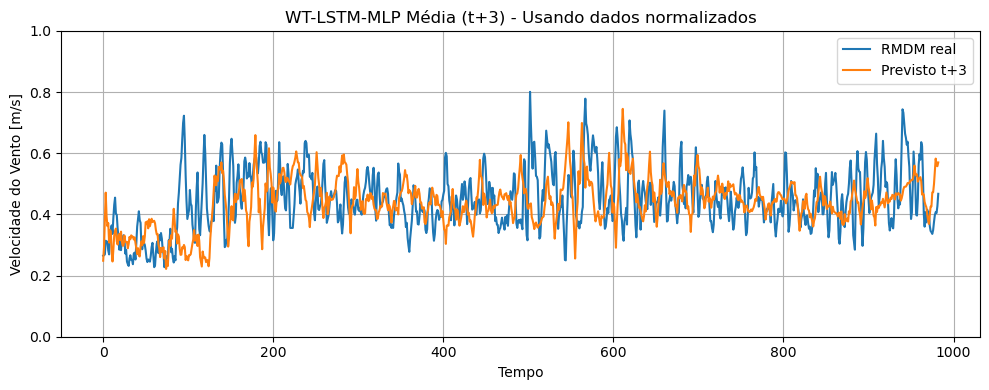


📊 Avaliando LSTM + MLP Média para t+5 (look_back=5)...
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
✅ RMSE: 0.1022 | MAE: 0.0788 | MAPE: 17.96% | C30%: 83.08%


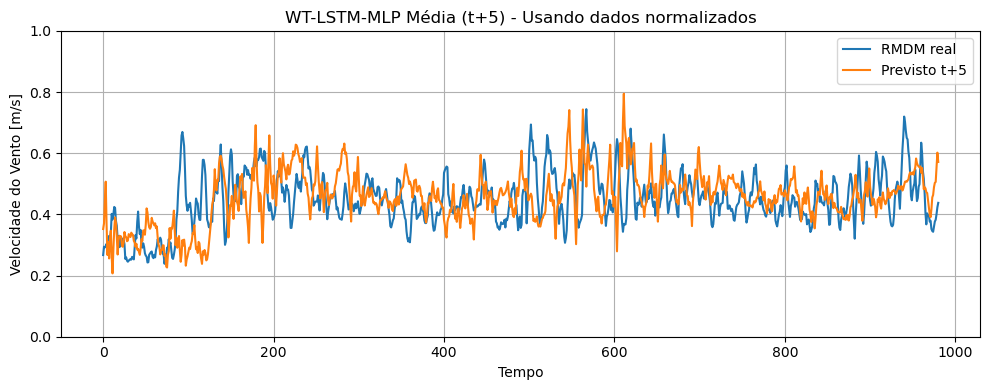


📊 Avaliando LSTM + MLP Média para t+7 (look_back=10)...
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
✅ RMSE: 0.0867 | MAE: 0.0660 | MAPE: 14.63% | C30%: 88.40%


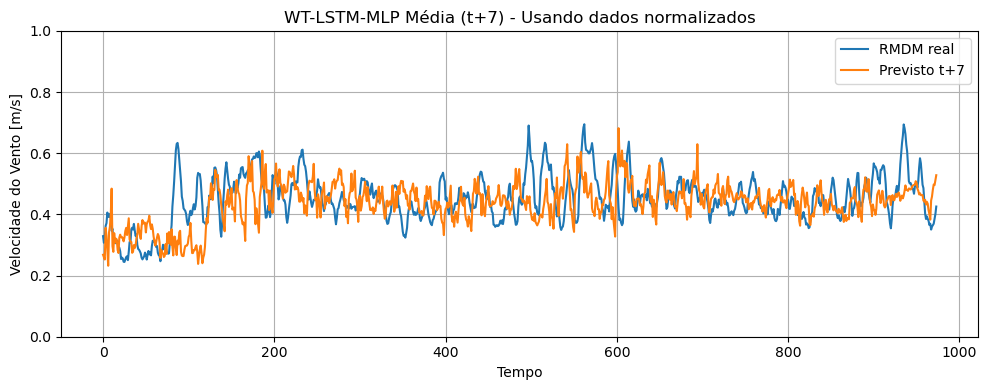


📊 Avaliando LSTM + MLP Média para t+30 (look_back=10)...
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
✅ RMSE: 0.0629 | MAE: 0.0482 | MAPE: 10.54% | C30%: 95.16%


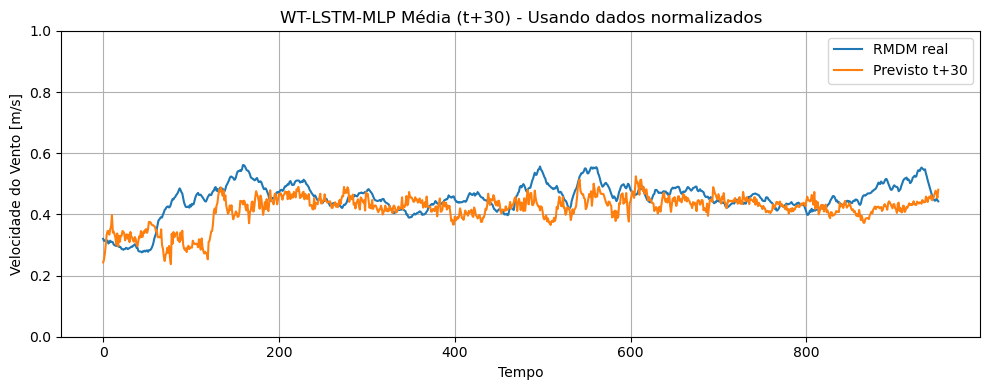


📊 Tabela final de métricas WT-LSTM-MLP Média:
       RMSE    MAE    MAPE     C30
t+1   0.134  0.106  24.993  67.310
t+3   0.112  0.086  19.451  79.349
t+5   0.102  0.079  17.958  83.078
t+7   0.087  0.066  14.633  88.398
t+30  0.063  0.048  10.535  95.163


In [63]:
from tensorflow.keras.models import load_model
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt

# Normalização original
MIN_RMDM = 1.1
MAX_RMDM = 25.0

# Criar dataset multi-step
def criar_dataset_com_media_futura(series, look_back=10, passo=1):
    X, y = [], []
    for i in range(len(series) - look_back - passo + 1):
        entrada = series[i:i+look_back]
        janela_futura = series[i+look_back:i+look_back+passo]
        media_futura = np.mean(janela_futura)
        X.append(entrada)
        y.append(media_futura)
    return np.array(X), np.array(y)

# Métricas
def calcular_metricas(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    c30 = np.sum((y_pred >= 0.7 * y_true) & (y_pred <= 1.3 * y_true)) / len(y_true) * 100
    return rmse, mae, mape, c30

# Previsão com MLP média
def prever_componente_mlp_media(nome_comp, passo, look_back):
    serie = pd.read_csv(f"{nome_comp}_component.csv")[nome_comp].values
    X, _ = criar_dataset_com_media_futura(serie, look_back=look_back, passo=passo)
    modelo = joblib.load(f"mlpavg_{nome_comp}_t{passo}.joblib")
    y_pred = modelo.predict(X)
    return y_pred

# Recomposição e avaliação
def recompor_e_avaliar_mlpavg(passo):
    look_back = 5 if passo in [1, 3, 5] else 10
    print(f"\n📊 Avaliando LSTM + MLP Média para t+{passo} (look_back={look_back})...")

    df = pd.read_csv("RMDM_corrigido.csv")
    rmdm_real = df["RMDM"].values

    df_norm = pd.read_csv("RMDM_corrigido_normalizado.csv")
    serie_norm = df_norm["RMDM_Norm"].values
    coeffs = pywt.wavedec(serie_norm, 'db4', level=3)
    a3 = pywt.upcoef('a', coeffs[0], 'db4', level=3)[:len(serie_norm)]

    X_a3, _ = criar_dataset_com_media_futura(a3, look_back=look_back, passo=passo)
    X_a3 = X_a3.reshape((X_a3.shape[0], X_a3.shape[1], 1))
    model_a3 = load_model(f"lstm_a3_t{passo}.keras")
    y_pred_a3 = model_a3.predict(X_a3).flatten()

    # Previsão dos detalhes NORMALIZADOS com MLP média
    y_pred_d3 = prever_componente_mlp_media("D3", passo, look_back)
    y_pred_d2 = prever_componente_mlp_media("D2", passo, look_back)
    y_pred_d1 = prever_componente_mlp_media("D1", passo, look_back)

    # Correção de picos (normalizados)
    limite_norm = 0.15  # por exemplo, 15% em [0,1]
    y_pred_d1_corr = np.clip(y_pred_d1, -limite_norm, limite_norm)
    y_pred_d2_corr = np.clip(y_pred_d2, -limite_norm, limite_norm)
    y_pred_d3_corr = np.clip(y_pred_d3, -limite_norm, limite_norm)

    min_len = min(len(y_pred_a3), len(y_pred_d1_corr), len(y_pred_d2_corr), len(y_pred_d3_corr))
    y_final_norm = (
        y_pred_a3[:min_len] +
        y_pred_d1_corr[:min_len] +
        y_pred_d2_corr[:min_len] +
        y_pred_d3_corr[:min_len]
    )
    y_final_norm = np.clip(y_final_norm, 0, 1)

    # Comparação diretamente em escala normalizada — agora com média real dos próximos `passo` dias
    
    rmdm_norm = df_norm["RMDM_Norm"].values
    y_real = []
    for i in range(len(rmdm_norm) - look_back - passo + 1):
        janela = rmdm_norm[i + look_back : i + look_back + passo]
        y_real.append(np.mean(janela))
    y_real = np.array(y_real[:min_len])

    y_final_real = y_final_norm


    rmse, mae, mape, c30 = calcular_metricas(y_real, y_final_real)
    print(f"✅ RMSE: {rmse:.4f} | MAE: {mae:.4f} | MAPE: {mape:.2f}% | C30%: {c30:.2f}%")

    plt.figure(figsize=(10, 4))
    plt.plot(y_real, label="RMDM real")
    plt.plot(y_final_real, label=f"Previsto t+{passo}")
    plt.title(f"WT-LSTM-MLP Média (t+{passo}) - Usando dados normalizados")
    plt.xlabel("Tempo")
    plt.ylabel("Velocidade do Vento [m/s]")
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1)  # <<<<<< AQUI!
    plt.tight_layout()
    plt.show()

    return {"t+{}".format(passo): {"RMSE": rmse, "MAE": mae, "MAPE": mape, "C30": c30}}

# Avaliar todos os horizontes
resultados_mlpavg = {}
for passo in [1, 3, 5, 7, 30]:
    res = recompor_e_avaliar_mlpavg(passo=passo)
    resultados_mlpavg.update(res)

# Tabela final
df_mlpavg_resultados = pd.DataFrame(resultados_mlpavg).T
print("\n📊 Tabela final de métricas WT-LSTM-MLP Média:")
print(df_mlpavg_resultados.round(3))


## MLP com nova topologia


📊 Avaliando LSTM + MLP Média para t+1 (look_back=5)...
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
✅ RMSE: 0.1366 | MAE: 0.1080 | MAPE: 25.86% | C30%: 66.60%


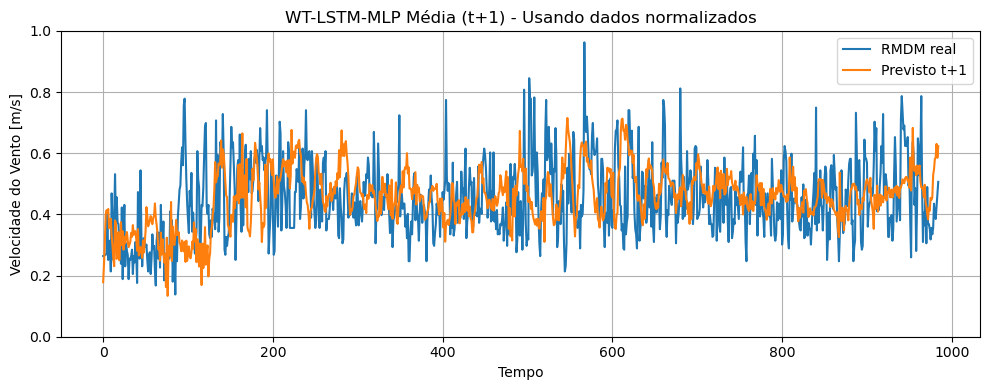


📊 Avaliando LSTM + MLP Média para t+3 (look_back=5)...
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
✅ RMSE: 0.1119 | MAE: 0.0864 | MAPE: 19.48% | C30%: 79.76%


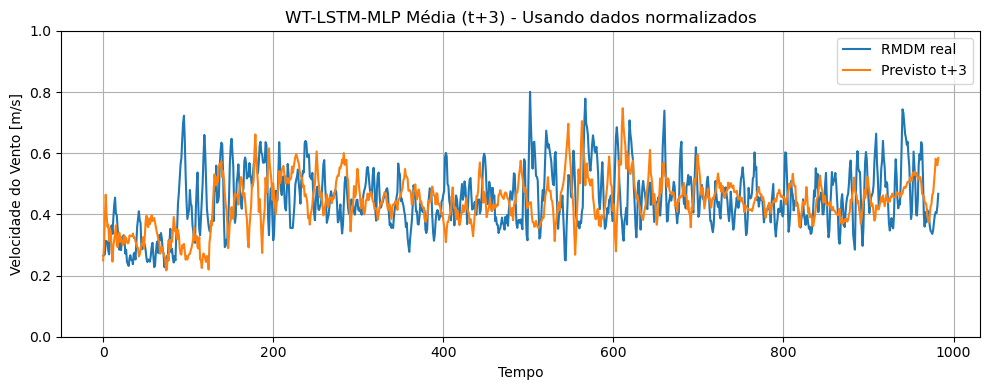


📊 Avaliando LSTM + MLP Média para t+5 (look_back=5)...
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
✅ RMSE: 0.1027 | MAE: 0.0785 | MAPE: 17.66% | C30%: 83.69%


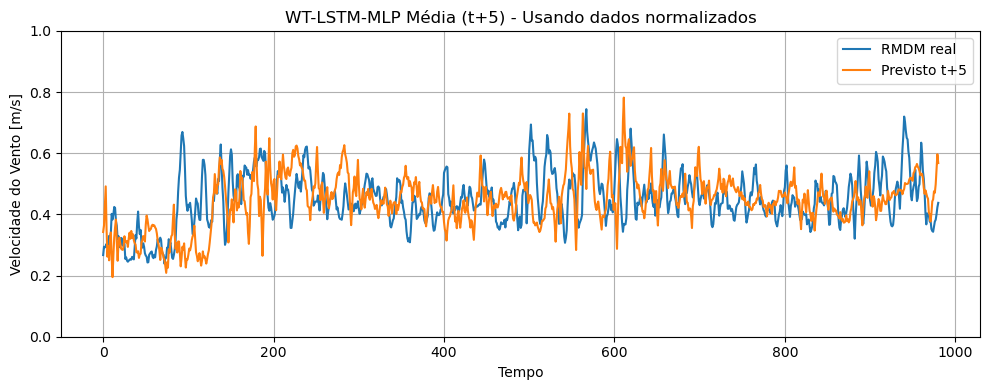


📊 Avaliando LSTM + MLP Média para t+7 (look_back=10)...
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
✅ RMSE: 0.0866 | MAE: 0.0657 | MAPE: 14.45% | C30%: 89.43%


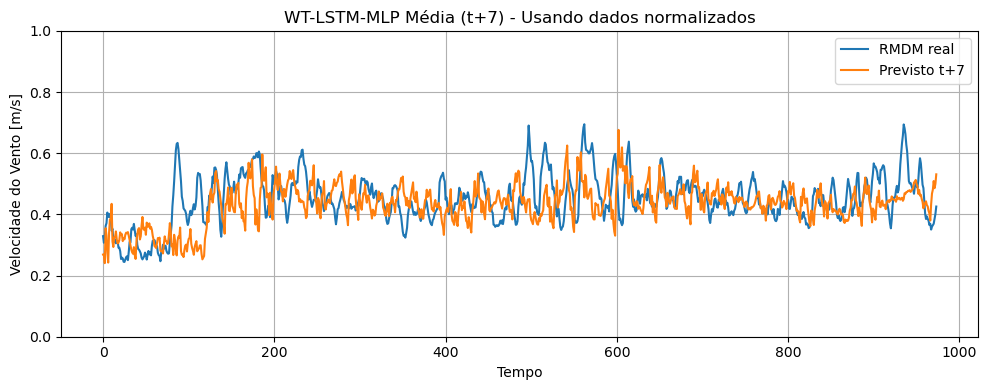


📊 Avaliando LSTM + MLP Média para t+30 (look_back=10)...
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
✅ RMSE: 0.0595 | MAE: 0.0457 | MAPE: 10.08% | C30%: 96.11%


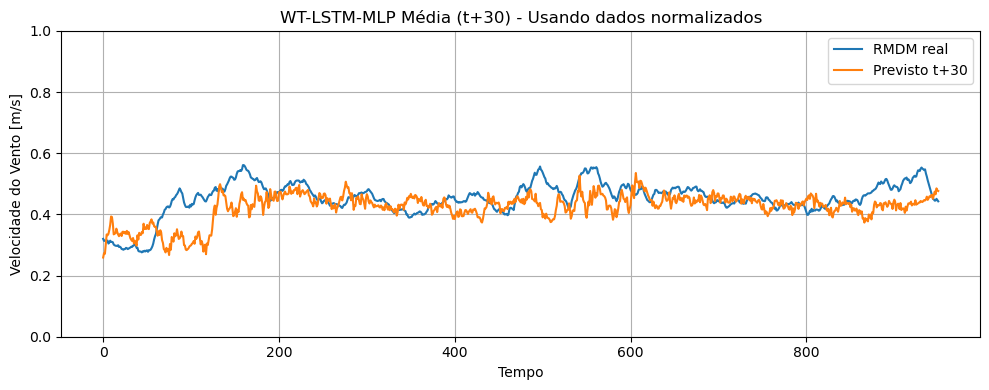


📊 Tabela final de métricas WT-LSTM-MLP Média:
       RMSE    MAE    MAPE     C30
t+1   0.137  0.108  25.858  66.599
t+3   0.112  0.086  19.480  79.756
t+5   0.103  0.078  17.658  83.690
t+7   0.087  0.066  14.449  89.425
t+30  0.060  0.046  10.083  96.109


In [64]:
from tensorflow.keras.models import load_model
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt

# Normalização original
MIN_RMDM = 1.1
MAX_RMDM = 25.0

# Criar dataset multi-step
def criar_dataset_com_media_futura(series, look_back=10, passo=1):
    X, y = [], []
    for i in range(len(series) - look_back - passo + 1):
        entrada = series[i:i+look_back]
        janela_futura = series[i+look_back:i+look_back+passo]
        media_futura = np.mean(janela_futura)
        X.append(entrada)
        y.append(media_futura)
    return np.array(X), np.array(y)

# Métricas
def calcular_metricas(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    c30 = np.sum((y_pred >= 0.7 * y_true) & (y_pred <= 1.3 * y_true)) / len(y_true) * 100
    return rmse, mae, mape, c30

# Previsão com MLP média
def prever_componente_mlp_media(nome_comp, passo, look_back):
    serie = pd.read_csv(f"{nome_comp}_component.csv")[nome_comp].values
    X, _ = criar_dataset_com_media_futura(serie, look_back=look_back, passo=passo)
    modelo = joblib.load(f"mlpavg_{nome_comp}_t{passo}.joblib")
    y_pred = modelo.predict(X)
    return y_pred

# Recomposição e avaliação
def recompor_e_avaliar_mlpavg(passo):
    look_back = 5 if passo in [1, 3, 5] else 10
    print(f"\n📊 Avaliando LSTM + MLP Média para t+{passo} (look_back={look_back})...")

    df = pd.read_csv("RMDM_corrigido.csv")
    rmdm_real = df["RMDM"].values

    df_norm = pd.read_csv("RMDM_corrigido_normalizado.csv")
    serie_norm = df_norm["RMDM_Norm"].values
    coeffs = pywt.wavedec(serie_norm, 'db4', level=3)
    a3 = pywt.upcoef('a', coeffs[0], 'db4', level=3)[:len(serie_norm)]

    X_a3, _ = criar_dataset_com_media_futura(a3, look_back=look_back, passo=passo)
    X_a3 = X_a3.reshape((X_a3.shape[0], X_a3.shape[1], 1))
    model_a3 = load_model(f"lstm_a3_t{passo}.keras")
    y_pred_a3 = model_a3.predict(X_a3).flatten()

    # Previsão dos detalhes NORMALIZADOS com MLP média
    y_pred_d3 = prever_componente_mlp_media("D3", passo, look_back)
    y_pred_d2 = prever_componente_mlp_media("D2", passo, look_back)
    y_pred_d1 = prever_componente_mlp_media("D1", passo, look_back)

    # Correção de picos (normalizados)
    limite_norm = 0.15  # por exemplo, 15% em [0,1]
    y_pred_d1_corr = np.clip(y_pred_d1, -limite_norm, limite_norm)
    y_pred_d2_corr = np.clip(y_pred_d2, -limite_norm, limite_norm)
    y_pred_d3_corr = np.clip(y_pred_d3, -limite_norm, limite_norm)

    min_len = min(len(y_pred_a3), len(y_pred_d1_corr), len(y_pred_d2_corr), len(y_pred_d3_corr))
    y_final_norm = (
        y_pred_a3[:min_len] +
        y_pred_d1_corr[:min_len] +
        y_pred_d2_corr[:min_len] +
        y_pred_d3_corr[:min_len]
    )
    y_final_norm = np.clip(y_final_norm, 0, 1)

    # Comparação diretamente em escala normalizada — agora com média real dos próximos `passo` dias
    
    rmdm_norm = df_norm["RMDM_Norm"].values
    y_real = []
    for i in range(len(rmdm_norm) - look_back - passo + 1):
        janela = rmdm_norm[i + look_back : i + look_back + passo]
        y_real.append(np.mean(janela))
    y_real = np.array(y_real[:min_len])

    y_final_real = y_final_norm


    rmse, mae, mape, c30 = calcular_metricas(y_real, y_final_real)
    print(f"✅ RMSE: {rmse:.4f} | MAE: {mae:.4f} | MAPE: {mape:.2f}% | C30%: {c30:.2f}%")

    plt.figure(figsize=(10, 4))
    plt.plot(y_real, label="RMDM real")
    plt.plot(y_final_real, label=f"Previsto t+{passo}")
    plt.title(f"WT-LSTM-MLP Média (t+{passo}) - Usando dados normalizados")
    plt.xlabel("Tempo")
    plt.ylabel("Velocidade do Vento [m/s]")
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1)  # <<<<<< AQUI!
    plt.tight_layout()
    plt.show()

    return {"t+{}".format(passo): {"RMSE": rmse, "MAE": mae, "MAPE": mape, "C30": c30}}

# Avaliar todos os horizontes
resultados_mlpavg = {}
for passo in [1, 3, 5, 7, 30]:
    res = recompor_e_avaliar_mlpavg(passo=passo)
    resultados_mlpavg.update(res)

# Tabela final
df_mlpavg_resultados = pd.DataFrame(resultados_mlpavg).T
print("\n📊 Tabela final de métricas WT-LSTM-MLP Média:")
print(df_mlpavg_resultados.round(3))


## Recomposição  completa com A3 par MLpregressor


📊 Avaliando MLP-Total para t+1 (look_back=5)...
✅ RMSE: 0.1354 | MAE: 0.1072 | MAPE: 25.49% | C30%: 67.72%


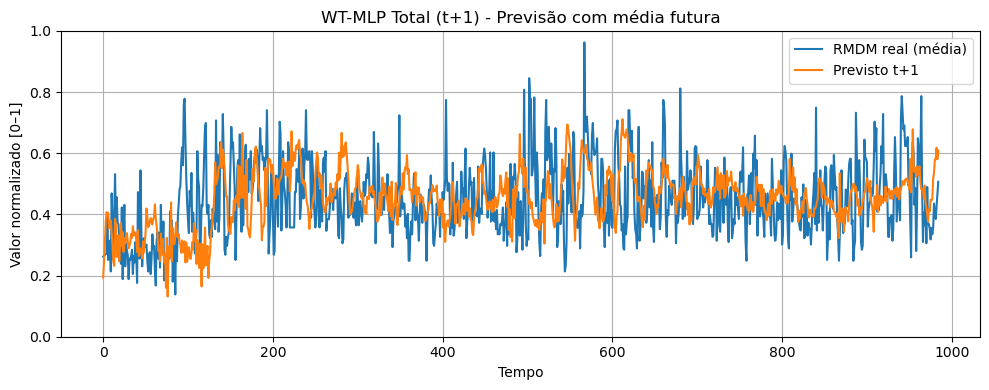


📊 Avaliando MLP-Total para t+3 (look_back=5)...
✅ RMSE: 0.1101 | MAE: 0.0864 | MAPE: 19.73% | C30%: 79.86%


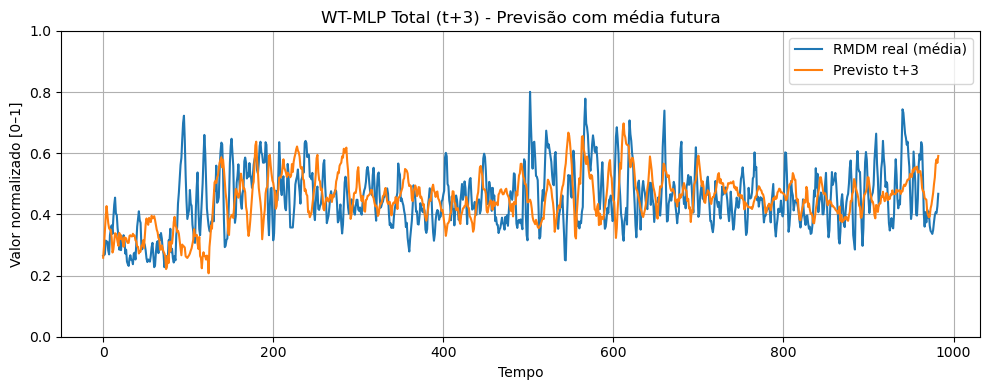


📊 Avaliando MLP-Total para t+5 (look_back=5)...
✅ RMSE: 0.0991 | MAE: 0.0761 | MAPE: 16.95% | C30%: 84.91%


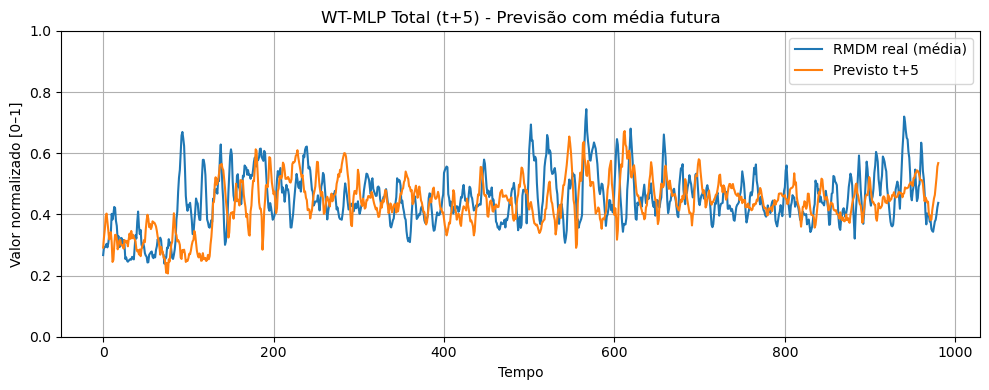


📊 Avaliando MLP-Total para t+7 (look_back=10)...
✅ RMSE: 0.0881 | MAE: 0.0674 | MAPE: 14.87% | C30%: 88.81%


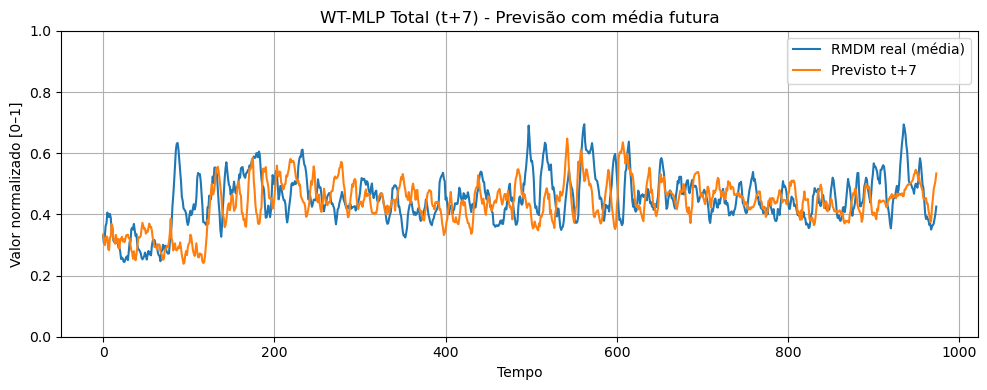


📊 Avaliando MLP-Total para t+30 (look_back=10)...
✅ RMSE: 0.0565 | MAE: 0.0423 | MAPE: 9.43% | C30%: 95.27%


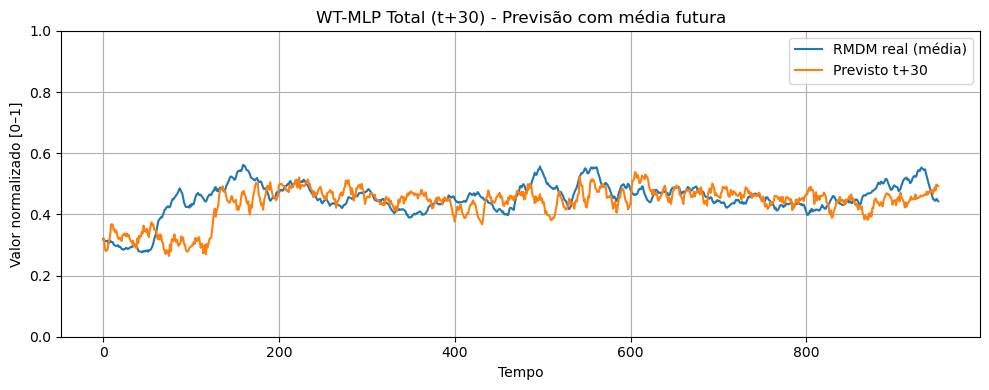


📊 Tabela final de métricas WT-MLP (Totalmente MLP):
       RMSE    MAE    MAPE     C30
t+1   0.135  0.107  25.492  67.716
t+3   0.110  0.086  19.725  79.858
t+5   0.099  0.076  16.945  84.913
t+7   0.088  0.067  14.872  88.809
t+30  0.057  0.042   9.431  95.268


In [65]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt
import joblib

# Calcular métricas
def calcular_metricas(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    c30 = np.sum((y_pred >= 0.7 * y_true) & (y_pred <= 1.3 * y_true)) / len(y_true) * 100
    return rmse, mae, mape, c30

# Criar dataset com média futura (normalizado)
def criar_dataset_media(series, look_back=10, passo=1):
    X, y = [], []
    for i in range(len(series) - look_back - passo + 1):
        entrada = series[i:i+look_back]
        janela_futura = series[i+look_back:i+look_back+passo]
        media_futura = np.mean(janela_futura)
        X.append(entrada)
        y.append(media_futura)
    return np.array(X), np.array(y)

# Previsão com MLP para A3
def prever_mlp_a3(passo, look_back, serie_norm):
    coeffs = pywt.wavedec(serie_norm, 'db4', level=3)
    a3 = pywt.upcoef('a', coeffs[0], 'db4', level=3)[:len(serie_norm)]
    X, _ = criar_dataset_media(a3, look_back=look_back, passo=passo)
    modelo = joblib.load(f"mlp_a3_t{passo}.joblib")
    return modelo.predict(X)

# Previsão com MLP para detalhes
def prever_mlp_detalhe(nome_comp, passo, look_back):
    serie = pd.read_csv(f"{nome_comp}_component.csv")[nome_comp].values
    X, _ = criar_dataset_media(serie, look_back=look_back, passo=passo)
    modelo = joblib.load(f"mlpavg_{nome_comp}_t{passo}.joblib")
    return modelo.predict(X)

# Função principal de recomposição
def recompor_e_avaliar_mlp_total(passo):
    look_back = 5 if passo in [1, 3, 5] else 10
    print(f"\n📊 Avaliando MLP-Total para t+{passo} (look_back={look_back})...")

    df = pd.read_csv("RMDM_litoral_norte_com_normalizado.csv")
    rmdm_norm = df["RMDM_Norm"].values

    # Previsões
    y_pred_a3 = prever_mlp_a3(passo, look_back, rmdm_norm)
    y_pred_d1 = prever_mlp_detalhe("D1", passo, look_back)
    y_pred_d2 = prever_mlp_detalhe("D2", passo, look_back)
    y_pred_d3 = prever_mlp_detalhe("D3", passo, look_back)

    # Correção de picos
    limite = 0.15
    y_pred_d1 = np.clip(y_pred_d1, -limite, limite)
    y_pred_d2 = np.clip(y_pred_d2, -limite, limite)
    y_pred_d3 = np.clip(y_pred_d3, -limite, limite)

    min_len = min(len(y_pred_a3), len(y_pred_d1), len(y_pred_d2), len(y_pred_d3))
    y_final = (
        y_pred_a3[:min_len] +
        y_pred_d1[:min_len] +
        y_pred_d2[:min_len] +
        y_pred_d3[:min_len]
    )
    y_final = np.clip(y_final, 0, 1)

    # Alvo: média futura real dos próximos `passo` dias (normalizado)
    y_real = []
    for i in range(len(rmdm_norm) - look_back - passo + 1):
        janela = rmdm_norm[i + look_back : i + look_back + passo]
        y_real.append(np.mean(janela))
    y_real = np.array(y_real[:min_len])

    # Métricas
    rmse, mae, mape, c30 = calcular_metricas(y_real, y_final)
    print(f"✅ RMSE: {rmse:.4f} | MAE: {mae:.4f} | MAPE: {mape:.2f}% | C30%: {c30:.2f}%")

    # Gráfico
    plt.figure(figsize=(10, 4))
    plt.plot(y_real, label="RMDM real (média)")
    plt.plot(y_final, label=f"Previsto t+{passo}")
    plt.title(f"WT-MLP Total (t+{passo}) - Previsão com média futura")
    plt.xlabel("Tempo")
    plt.ylabel("Valor normalizado [0–1]")
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {"t+{}".format(passo): {"RMSE": rmse, "MAE": mae, "MAPE": mape, "C30": c30}}

# Loop para todos os passos
resultados_mlp_total = {}
for passo in [1, 3, 5, 7, 30]:
    res = recompor_e_avaliar_mlp_total(passo=passo)
    resultados_mlp_total.update(res)

# Tabela final
df_mlp_total = pd.DataFrame(resultados_mlp_total).T
print("\n📊 Tabela final de métricas WT-MLP (Totalmente MLP):")
print(df_mlp_total.round(3))



📊 Avaliando MLP-Total para t+1 (look_back=5)...
✅ RMSE: 0.1354 | MAE: 0.1072 | MAPE: 25.49% | C30%: 67.72%
🔁 RMSE_real: 3.2368 | MAE_real: 2.5618


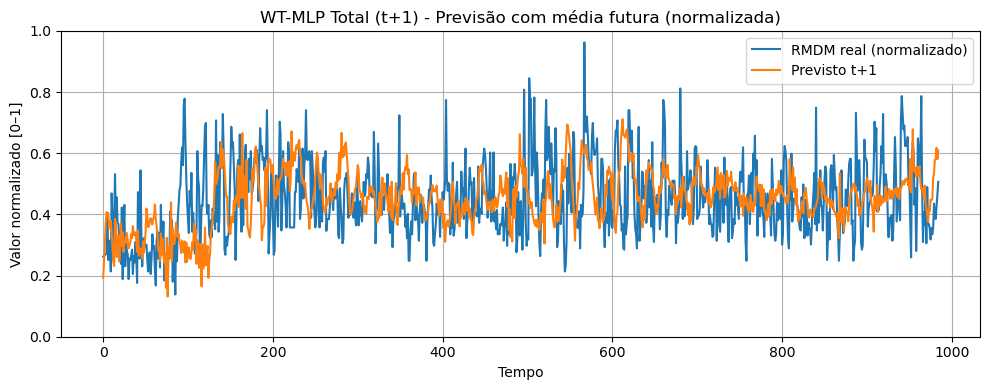


📊 Avaliando MLP-Total para t+3 (look_back=5)...
✅ RMSE: 0.1101 | MAE: 0.0864 | MAPE: 19.73% | C30%: 79.86%
🔁 RMSE_real: 2.6303 | MAE_real: 2.0659


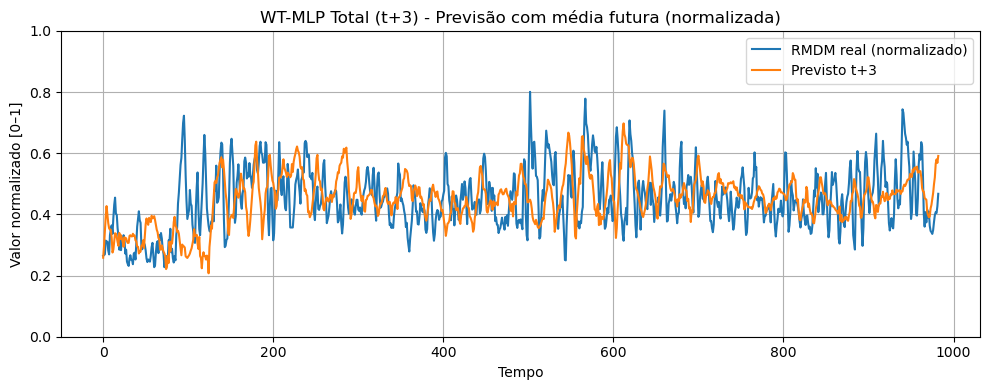


📊 Avaliando MLP-Total para t+5 (look_back=5)...
✅ RMSE: 0.0991 | MAE: 0.0761 | MAPE: 16.95% | C30%: 84.91%
🔁 RMSE_real: 2.3687 | MAE_real: 1.8189


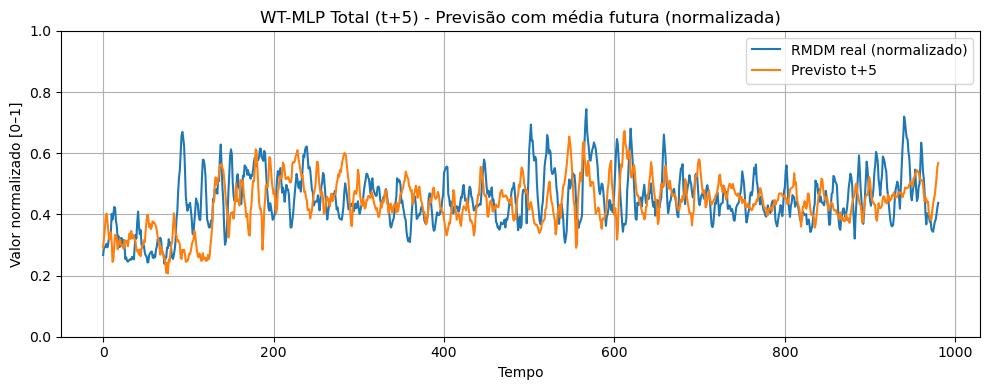


📊 Avaliando MLP-Total para t+7 (look_back=10)...
✅ RMSE: 0.0881 | MAE: 0.0674 | MAPE: 14.87% | C30%: 88.81%
🔁 RMSE_real: 2.1066 | MAE_real: 1.6101


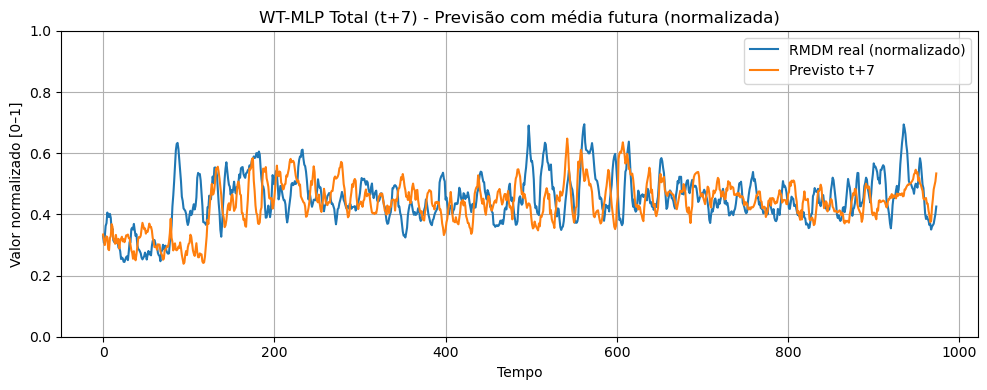


📊 Avaliando MLP-Total para t+30 (look_back=10)...
✅ RMSE: 0.0565 | MAE: 0.0423 | MAPE: 9.43% | C30%: 95.27%
🔁 RMSE_real: 1.3509 | MAE_real: 1.0111


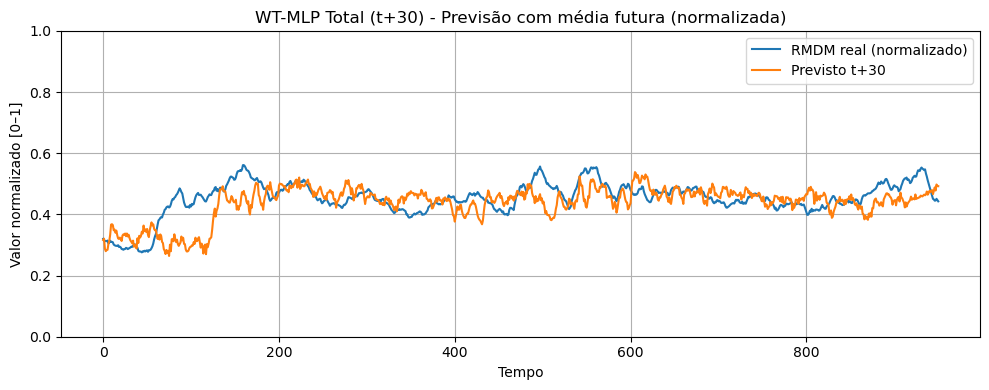


📊 Tabela final de métricas WT-MLP (com desnormalização):
       RMSE    MAE    MAPE     C30  RMSE_real  MAE_real
t+1   0.135  0.107  25.492  67.716      3.237     2.562
t+3   0.110  0.086  19.725  79.858      2.630     2.066
t+5   0.099  0.076  16.945  84.913      2.369     1.819
t+7   0.088  0.067  14.872  88.809      2.107     1.610
t+30  0.057  0.042   9.431  95.268      1.351     1.011


In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt
import joblib

# Calcular métricas
def calcular_metricas(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    c30 = np.sum((y_pred >= 0.7 * y_true) & (y_pred <= 1.3 * y_true)) / len(y_true) * 100
    return rmse, mae, mape, c30

# Criar dataset com média futura (normalizado)
def criar_dataset_media(series, look_back=10, passo=1):
    X, y = [], []
    for i in range(len(series) - look_back - passo + 1):
        entrada = series[i:i+look_back]
        janela_futura = series[i+look_back:i+look_back+passo]
        media_futura = np.mean(janela_futura)
        X.append(entrada)
        y.append(media_futura)
    return np.array(X), np.array(y)

# Previsão com MLP para A3
def prever_mlp_a3(passo, look_back, serie_norm):
    coeffs = pywt.wavedec(serie_norm, 'db4', level=3)
    a3 = pywt.upcoef('a', coeffs[0], 'db4', level=3)[:len(serie_norm)]
    X, _ = criar_dataset_media(a3, look_back=look_back, passo=passo)
    modelo = joblib.load(f"mlp_a3_t{passo}.joblib")
    return modelo.predict(X)

# Previsão com MLP para detalhes
def prever_mlp_detalhe(nome_comp, passo, look_back):
    serie = pd.read_csv(f"{nome_comp}_component.csv")[nome_comp].values
    X, _ = criar_dataset_media(serie, look_back=look_back, passo=passo)
    modelo = joblib.load(f"mlpavg_{nome_comp}_t{passo}.joblib")
    return modelo.predict(X)

# Função principal de recomposição
# Função principal
def recompor_e_avaliar_mlp_total(passo):
    look_back = 5 if passo in [1, 3, 5] else 10
    print(f"\n📊 Avaliando MLP-Total para t+{passo} (look_back={look_back})...")

    df = pd.read_csv("RMDM_litoral_norte_com_normalizado.csv")
    rmdm_norm = df["RMDM_Norm"].values

    # Prever A3 e detalhes
    y_pred_a3 = prever_mlp_a3(passo, look_back, rmdm_norm)
    y_pred_d1 = prever_mlp_detalhe("D1", passo, look_back)
    y_pred_d2 = prever_mlp_detalhe("D2", passo, look_back)
    y_pred_d3 = prever_mlp_detalhe("D3", passo, look_back)

    # Corrigir extremos (picos)
    limite = 0.15
    y_pred_d1 = np.clip(y_pred_d1, -limite, limite)
    y_pred_d2 = np.clip(y_pred_d2, -limite, limite)
    y_pred_d3 = np.clip(y_pred_d3, -limite, limite)

    min_len = min(len(y_pred_a3), len(y_pred_d1), len(y_pred_d2), len(y_pred_d3))
    y_final_norm = (
        y_pred_a3[:min_len] +
        y_pred_d1[:min_len] +
        y_pred_d2[:min_len] +
        y_pred_d3[:min_len]
    )
    y_final_norm = np.clip(y_final_norm, 0, 1)

    # Gerar y_real normalizado
    y_real_norm = []
    for i in range(len(rmdm_norm) - look_back - passo + 1):
        janela = rmdm_norm[i + look_back : i + look_back + passo]
        y_real_norm.append(np.mean(janela))
    y_real_norm = np.array(y_real_norm[:min_len])

    # 🔍 Métricas normalizadas
    rmse, mae, mape, c30 = calcular_metricas(y_real_norm, y_final_norm)

    # 🔄 Desnormalização para métricas reais
    MIN_RMDM = 1.1
    MAX_RMDM = 25.0
    y_real_real = y_real_norm * (MAX_RMDM - MIN_RMDM) + MIN_RMDM
    y_final_real = y_final_norm * (MAX_RMDM - MIN_RMDM) + MIN_RMDM

    rmse_real = np.sqrt(mean_squared_error(y_real_real, y_final_real))
    mae_real = mean_absolute_error(y_real_real, y_final_real)

    # ✅ Impressão
    print(f"✅ RMSE: {rmse:.4f} | MAE: {mae:.4f} | MAPE: {mape:.2f}% | C30%: {c30:.2f}%")
    print(f"🔁 RMSE_real: {rmse_real:.4f} | MAE_real: {mae_real:.4f}")

    # 📈 Gráfico
    plt.figure(figsize=(10, 4))
    plt.plot(y_real_norm, label="RMDM real (normalizado)")
    plt.plot(y_final_norm, label=f"Previsto t+{passo}")
    plt.title(f"WT-MLP Total (t+{passo}) - Previsão com média futura (normalizada)")
    plt.xlabel("Tempo")
    plt.ylabel("Valor normalizado [0–1]")
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {
        f"t+{passo}": {
            "RMSE": rmse,
            "MAE": mae,
            "MAPE": mape,
            "C30": c30,
            "RMSE_real": rmse_real,
            "MAE_real": mae_real
        }
    }

resultados_mlp_total = {}
for passo in [1, 3, 5, 7, 30]:
    res = recompor_e_avaliar_mlp_total(passo=passo)
    resultados_mlp_total.update(res)

df_mlp_total = pd.DataFrame(resultados_mlp_total).T
print("\n📊 Tabela final de métricas WT-MLP (com desnormalização):")
print(df_mlp_total.round(3))


In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pywt
import joblib

def scatter_com_bandas_wt_mlp():
    passos = [1, 3, 5, 7, 30]
    rotulos = ['(a)', '(b)', '(c)', '(d)', '(e)']
    titulos = [
        "1 day", "3 days", "5 days", "1 week", "30 days"
    ]

    MIN_RMDM, MAX_RMDM = 1.1, 25.0
    fator = MAX_RMDM - MIN_RMDM

    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    axes = axes.flatten()

    for idx, passo in enumerate(passos):
        look_back = 5 if passo in [1, 3, 5] else 10

        df = pd.read_csv("RMDM_litoral_norte_com_normalizado.csv")
        rmdm_norm = df["RMDM_Norm"].values

        # === A3 ===
        coeffs = pywt.wavedec(rmdm_norm, 'db4', level=3)
        a3 = pywt.upcoef('a', coeffs[0], 'db4', level=3)[:len(rmdm_norm)]
        X_a3, _ = criar_dataset_media(a3, look_back, passo)
        y_a3 = joblib.load(f"mlp_a3_t{passo}.joblib").predict(X_a3)

        # === Detalhes ===
        def prev(nome):
            serie = pd.read_csv(f"{nome}_component.csv")[nome].values
            X, _ = criar_dataset_media(serie, look_back, passo)
            return joblib.load(f"mlpavg_{nome}_t{passo}.joblib").predict(X)

        y_d1 = np.clip(prev("D1"), -0.15, 0.15)
        y_d2 = np.clip(prev("D2"), -0.15, 0.15)
        y_d3 = np.clip(prev("D3"), -0.15, 0.15)

        # === Recomposição ===
        min_len = min(len(y_a3), len(y_d1), len(y_d2), len(y_d3))
        y_pred_norm = y_a3[:min_len] + y_d1[:min_len] + y_d2[:min_len] + y_d3[:min_len]
        y_pred_norm = np.clip(y_pred_norm, 0, 1)
        y_pred_real = y_pred_norm * fator + MIN_RMDM

        # === Real: média futura ===
        y_real = []
        for i in range(len(rmdm_norm) - look_back - passo + 1):
            janela = rmdm_norm[i + look_back : i + look_back + passo]
            y_real.append(np.mean(janela))
        y_real_norm = np.array(y_real[:min_len])
        y_real_real = y_real_norm * fator + MIN_RMDM

        # === Gráfico ===
        ax = axes[idx]
        ax.scatter(y_real_real, y_pred_real, s=12, alpha=0.5, color="black")

        # Linha ideal
        min_v = min(y_real_real.min(), y_pred_real.min())
        max_v = max(y_real_real.max(), y_pred_real.max())
        ref = np.linspace(min_v, max_v, 200)
        ax.plot(ref, ref, 'k-', linewidth=1, label='Ideal')

        # Bandas ±30%
        ax.fill_between(ref, 0.7 * ref, 1.3 * ref, color='gray', alpha=0.15, label='±30% band')
        ax.set_title(f"Wind Speed for next {titulos[idx]} using WT-MLP", fontsize=11)
        ax.set_xlabel("Actual Values [m/s]")
        ax.set_ylabel("Predicted Values [m/s]")
        ax.grid(True)
        ax.set_aspect('equal', adjustable='box')
        ax.set_xlim([min_v, max_v])
        ax.set_ylim([min_v, max_v])
        ax.text(0.05, 0.91, rotulos[idx], transform=ax.transAxes, fontsize=12, fontweight='bold')

        if idx == 0:
            ax.legend(loc="upper left", fontsize=9)

    fig.delaxes(axes[-1])  # remove o último slot se vazio
    plt.tight_layout()
    plt.suptitle("Scatter plots of actual and forecasted values using WT-MLP", fontsize=16, y=1.03)
    plt.subplots_adjust(hspace=0.4, wspace=0.3)
    plt.show()


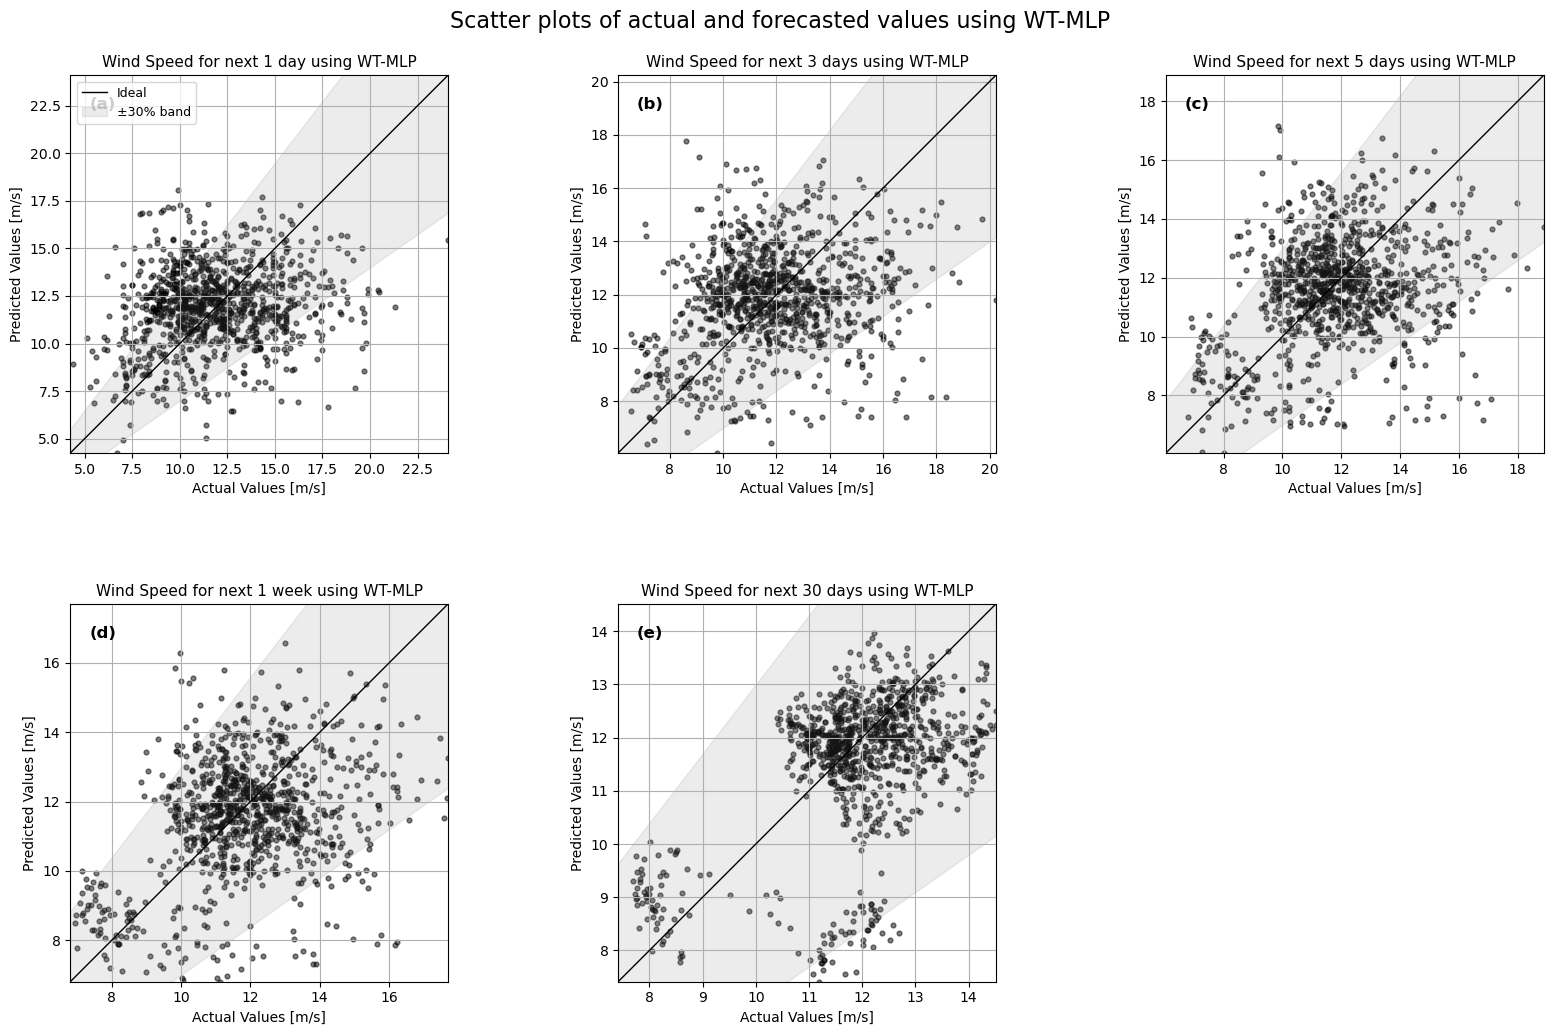

In [10]:
scatter_com_bandas_wt_mlp()